In [1]:
library(Signac)
library(Seurat)
library(glue)
library(EnsDb.Mmusculus.v79)
library(ggsci)
library(ComplexHeatmap)
base_dir='./placeholder_project/code/'
CodePath = glue('{base_dir}/ATAC_pipeline_zyr/Code/')
source(file.path(CodePath,'Function/PipelineFuncHtml.R'))
source(file.path(CodePath,'Function/LoadsingleSample.func.R'))
source(file.path(CodePath,'Function/MotifAnalysis.func.R'))
source(file.path(CodePath,'Function/Signac.Heatmap.R'))
source(file.path(CodePath,'Function/ClusterAndTypeing.func.R'))
source(file.path(CodePath,'Function/cCREsStatistics.func.R'))
source(file.path(CodePath,'Function/Signac.Heatmap.R'))
source(file.path(CodePath,'Function/MergeSampleObj.R'))
source(file.path(CodePath,'Function/PredictCellType.R'))

setwd('./placeholder_project/code/')
source('./placeholder_project/code/jupyter_R/myFun.R')
source('./placeholder_project/code/jupyter_R/markerlist.R')
my_process_srt <- function(object, assay){
  DefaultAssay(object) <- assay
  object <- RunTFIDF(object)
  object <- FindTopFeatures(object, min.cutoff = 'q5',verbose = F)
  object <- RunSVD(object,verbose = F)
  object <- RunUMAP(object = object, reduction = 'lsi', dims = 2:30)
  object <- FindNeighbors(object = object, reduction = 'lsi', dims = 2:30 )
  object <- FindClusters(object = object, verbose = FALSE, algorithm = 3)
  return(object)
}
myRowScale<-function(m = NULL, min = -2, max = 2, limit = FALSE){
    z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
    if(limit){
        z[z > max] <- max
        z[z < min] <- min
    }
    return(z)
}
myAveragePeak <- function(object,groupby, assay=NULL, slot = 'data'){
    if(!is.null(assay)){
        DefaultAssay(object) = assay
    }else{
        assay = DefaultAssay(object)
    }
    Idents(object) = object@meta.data[[groupby]]
    clusters =  unique(Idents(object))
    mat =  GetAssayData(object,assay = assay, slot)
    
    j = 1
    for (i in clusters) {
        #i = clusters[2]
        subBarcode = WhichCells(object = object,idents = i)
        sub_mat = mat[,subBarcode,drop=F] 
        mean.c = rowMeans(sub_mat)
        if(is.numeric(i)){
            Clu = paste0('C',i)
        }else{
            Clu = i
        }
       
        if (j == 1) {
            eval(parse(text = paste0('mean.mat = data.frame(`',Clu,'`= mean.c)')))
        }else{
            mean.mat[,Clu] = mean.c
        }
        j = j+1
    }
    return(mean.mat)
}
base_path='./placeholder_analysis/round_cluster02/cCRE/'

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading

In [2]:
expanded_colors <- c(
  "#D7191C", "#E6804D", "#FF6F61", "#F18A99", "#E6AB02",
  "#D95F02", "#FFB347", "#E4A8A3", "#EBEBEB", "#FADFC3",
  "#A6CD48", "#A0D6F7", "#94D3B6", "#FDAE61", "#FEE08B",
  "#A6D96A", "#1F78B4", "#7570B3", "#A6761D", "#D73027",
  "#ABDDA4", "#2B83BA", "#F46D43", "#D8B365", "#BDBDBD",
  "#A6BD8B", "#C9948B", "#D6616B", "#7B9E23", "#B69DAE",
  "#73C2A3", "#969696", "#6A9AC4", "#B97CAA", "#7AAE3C",
  "#D5B8E5", "#4DBBD5FF", "#E64B35FF", "#00A087FF", "#A65628",
  "#FF95A8FF", "#BCBD22FF", "#FDBF6F", "#3C5488FF", "#F39B7FFF",
  "#B09C85FF", "#7876B1FF", "#377EB8", "#4DAF4A", "#97A1A7FF",
  "#984EA3", "#FF7F00", "#F781BF", "#B2DF8A", "#5050FFFF",
  "#82581FFF", "#E5614CFF", "#F0E685FF", "#D595A7FF", "#CDDEB7FF",
  "#612A79FF", "#AE1F63FF", "#1B1919FF", "#99CC00FF", "#CC9900FF",
  "#9467BDFF", "#EFD500FF", "#ADE2D0FF", "#CE3D32FF", "#749B58FF",
  "#466983FF", "#BA6338FF", "#5DB1DDFF", "#802268FF", "#6BD76BFF",
  "#924822FF", "#837B8DFF", "#C75127FF", "#D58F5CFF", "#7A65A5FF",
  "#E4AF69FF", "#3B1B53FF", "#E7C76FFF", "#5A655EFF", "#33CC00FF",
  "#00CC33FF", "#00CC99FF", "#0099CCFF", "#0A47FFFF", "#4775FFFF",
  "#FFC20AFF", "#FFD147FF", "#990033FF", "#991A00FF", "#996600FF",
  "#809900FF", "#339900FF", "#00991AFF", "#009966FF", "#008099FF",
  "#003399FF", "#1A0099FF", "#660099FF", "#990080FF", "#D60047FF",
  "#FF1463FF", "#00D68FFF",
  # 50 new colors
  "#C22E29", "#F68712", "#FCD34D", "#16A34A", "#10B981",
  "#0EA5E9", "#6366F1", "#8B5CF6", "#EC4899", "#F43F5E",
  "#FF9F43", "#FFDA77", "#A3E635", "#4ADE80", "#2DD4BF",
  "#38BDF8", "#818CF8", "#A78BFA", "#E879F9", "#F87171",
  "#EF4444", "#FB923C", "#FACC15", "#84CC16", "#22D3EE",
  "#60A5FA", "#818CF8", "#C084FC", "#F472B6", "#FB7185",
  "#DC2626", "#EA580C", "#FBBF24", "#4D7C0F", "#064E3B",
  "#0F766E", "#075985", "#4338CA", "#6D28D9", "#DB2777",
  "#9D174D", "#7C2D12", "#78350F", "#365314", "#14532D",
  "#164E63", "#1E3A8A", "#312E81", "#581C87", "#701A75"
)
expanded_colors2 = c("#4dbbd5ff" ,"#E64b35ff", "#00a087ff" ,"#a65628", "#FF95A8FF","#BCBD22FF", "#fdbf6f", "#3c5488ff",
                   "#f39b7fff", "#b09c85ff", "#7876b1ff", "#377eb8",  "#4daf4a","#97A1A7FF" ,
                   "#984ea3" , "#ff7f00",  "#f781bf", "#b2df8a", "#5050FFFF", "#82581FFF" , "#E5614CFF",
                   "#F0E685FF", "#D595A7FF", "#CDDEB7FF","#612A79FF" ,"#AE1F63FF","#1B1919FF",
                   "#99CC00FF","#CC9900FF" ,"#9467BDFF", "#EFD500FF" , "#ADE2D0FF",pal_igv()(50))

In [3]:
pt_to_mm <- function(pt) {
  pt /2.13
}
label_size <-function(x){
    x/2.8453
}
mytheme =     theme_void()+
      theme(panel.border = element_rect(linewidth=pt_to_mm(0.25),fill=NA),
            plot.title = element_text(hjust = 0.5,face = "plain", size=8, margin = margin(t = 0, r = 0, b = 2, l = 0, unit = "pt")),

            axis.title = element_text(size=7),
            axis.title.y= element_text(angle = 90,hjust=0.5, margin = margin(t = 0, r = 2, b = 0, l = 0, unit = "pt")),
            axis.title.x= element_text(margin = margin(t = 2, r = 0, b = 0, l = 0, unit = "pt")),

            axis.text = element_text(size=6),
            axis.text.x = element_text(margin = margin(t = 1, r = 0, b = 0, l = 0, unit = "pt")),
            axis.text.y = element_text(margin = margin(t = 0, r = 1, b = 0, l = 0, unit = "pt")),

            axis.ticks = element_line(size = pt_to_mm(0.2)),
            axis.ticks.length =  unit(1, 'pt'),
            
            legend.spacing = unit(2, 'pt'),
            legend.key.width = unit(3, "mm"),  # Legend color bar width
            legend.key.height = unit(3, "mm"),    # Legend color bar height
            legend.key.spacing = unit(2, 'pt'),
            
            legend.text = element_text(size=6),
            legend.title = element_text(size=6,face = "plain"),
            legend.margin = margin(0, 0, 0, 0)
            )

In [5]:
umap = read.csv(glue('./placeholder_analysis/round_cluster02/merge/cell_meta.csv'))

In [6]:
new_celltype = read.csv('./placeholder_analysis/round_cluster02/merge/celltype_modify.csv')

In [8]:
head(new_celltype)

Celltype_round1 Celltype_round2 Celltype_round3    Celltype_round4    n    
1 Endothelium     EC_Arterial     EC_Arterial_Col4a1 EC_Arterial_Col4a1  9502
2 Endothelium     EC_Arterial     EC_Arterial_Gria2  EC_Arterial_Gria2   1025
3 Endothelium     EC_Arterial     EC_Arterial_Lypd6  EC_Arterial_Lypd6  12609
4 Endothelium     EC_Grid1        EC_Grid1           EC_Grid1           73130
5 Endothelium     EC_Lfrn1        EC_Lfrn1           EC_Lfrn1           21577
6 Endothelium     EC_Venous       EC_Venous          EC_Venous           3406
  cluster_num MainType SubType  Celltype_round4_new
1  86         EC       Arterial Arterial_Col4a1    
2  25         EC       Arterial Arterial_Gria2     
3 104         EC       Arterial Arterial_Lypd6     
4 128         EC       EC       EC_Grid1           
5 117         EC       EC       EC_Lfrn1           
6  54         EC       Venous   Venous

In [26]:
output_dir='./placeholder_output/raw_figure_output/Figure4/'

# CRE nearest gene enrichment

In [10]:
library(chromVAR)
library(motifmatchr)
library(TFBSTools)

library(BSgenome.Mmusculus.UCSC.mm10)
jaspar <- JASPAR2024::JASPAR2024()
pfm <- getMatrixSet(
  x = jaspar@db,opts = list(collection = "CORE",tax_group='vertebrates' , all_versions = FALSE))
hg38_mm10_TF_mapping = read.table('../hg38_mm10_TF_mapping.txt', sep='\t', header = TRUE)
keep_TF = unique(hg38_mm10_TF_mapping$tf_name)
keep_TF_upper = toupper(keep_TF)

dup_tf = keep_TF_upper[duplicated(keep_TF_upper)]

keep_TF = setdiff(keep_TF,dup_tf)
length(keep_TF)
keep_TF_motifname = c()
for(i in pfm@listData){
    if(i@name %in% keep_TF){
        keep_TF_motifname = c(keep_TF_motifname,i@ID)
    }
}
pfm_filter = pfm[names(pfm)%in%keep_TF_motifname]
pfm_filter


[1] 731

PFMatrixList of length 719
names(719): MA0004.1 MA0069.1 MA0071.1 MA0074.1 ... MA1717.2 MA1721.2 MA1602.2

In [8]:

base_path='./placeholder_analysis/round_cluster02/cCRE/'
srt = readRDS(glue('{base_path}/celltype_rds/Epi_sub.rds'))
srt

An object of class Seurat 
714140 features across 169762 samples within 2 assays 
Active assay: CRE (713987 features, 684342 variable features)
 2 layers present: counts, data
 1 other assay present: chromvar
 2 dimensional reductions calculated: lsi, umap

In [ ]:

srt <- AddMotifs(object = srt,
                 genome = BSgenome.Mmusculus.UCSC.mm10,
                 pfm = pfm_filter,verbose = F)

In [13]:
motif_meta = c()
for(m in pfm_filter@listData){
    motif_meta = rbind(motif_meta, c(m@ID, paste0(m@tags$family,collapse = '::'), m@name))
}
motif_meta = as.data.frame(motif_meta)
colnames(motif_meta) = c('motif', 'family', 'TF')
rownames(motif_meta) = motif_meta$motif

In [14]:
srt@meta.data[,'new_group'] = paste0(srt$Celltype_round4,':',srt$Time)

Idents(srt) = srt$new_group

In [ ]:
srt_markers_new = c()
for(i in unique(srt$Celltype_round4)){
    message(i)
    tmp_srt = subset(srt, Celltype_round4==i)
    Idents(tmp_srt) = tmp_srt$new_group
    tmp_srt_markers = FindAllMarkers(tmp_srt, 
                                     test.use = 'wilcox', 
                                     min.pct = 0.01,
                                     logfc.threshold = 0.1,
                                     max.cells.per.ident=500)
    srt_markers_new = rbind(srt_markers_new, tmp_srt_markers)
}

AT1

Calculating cluster AT1:P5

Calculating cluster AT1:P8

Calculating cluster AT1:P0

Calculating cluster AT1:P11

Calculating cluster AT1:P14

Calculating cluster AT1:P13

Calculating cluster AT1:P1

Calculating cluster AT1:P7

Calculating cluster AT1:P6

Calculating cluster AT1:P3

Calculating cluster AT1:P12

Calculating cluster AT1:P10

Calculating cluster AT1:P9

Calculating cluster AT1:P2

Calculating cluster AT1:P4

AT1_Nek10

Calculating cluster AT1_Nek10:P5

Calculating cluster AT1_Nek10:P8

Calculating cluster AT1_Nek10:P0

Calculating cluster AT1_Nek10:P11

Calculating cluster AT1_Nek10:P14

Calculating cluster AT1_Nek10:P13

Calculating cluster AT1_Nek10:P1

Calculating cluster AT1_Nek10:P7

Calculating cluster AT1_Nek10:P6

Calculating cluster AT1_Nek10:P3

Calculating cluster AT1_Nek10:P12

Calculating cluster AT1_Nek10:P10

Calculating cluster AT1_Nek10:P9

Calculating cluster AT1_Nek10:P2

Calculating cluster AT1_Nek10:P4

AT1_Agt

Calculating cluster AT1_Agt:P5

Cal

In [ ]:
head(srt_markers_new)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr8-25227098-25227599   1.140961e-12 0.4107451  0.740 0.573 8.146314e-07
chr4-106859396-106859897 1.790030e-05 0.6240192  0.066 0.042 1.000000e+00
chr11-97048164-97048665  2.897830e-05 0.9712911  0.031 0.015 1.000000e+00
chr7-27486662-27487163   3.608356e-05 0.1752675  0.101 0.085 1.000000e+00
chr14-26579698-26580199  6.394505e-05 0.4138047  0.032 0.023 1.000000e+00
chr3-89279423-89279924   8.331390e-05 0.4430986  0.061 0.044 1.000000e+00
                         cluster gene                    
chr8-25227098-25227599   AT1:P5  chr8-25227098-25227599  
chr4-106859396-106859897 AT1:P5  chr4-106859396-106859897
chr11-97048164-97048665  AT1:P5  chr11-97048164-97048665 
chr7-27486662-27487163   AT1:P5  chr7-27486662-27487163  
chr14-26579698-26580199  AT1:P5  chr14-26579698-26580199 
chr3-89279423-89279924   AT1:P5  chr3-89279423-89279924

In [371]:
saveRDS(srt_markers_new, './placeholder_analysis/round_cluster02/cCRE/Epi_sub_marker_new.rds')

In [16]:
srt_markers = readRDS('./placeholder_analysis/round_cluster02/cCRE/Epi_sub_marker_new.rds')

In [17]:
load_peak<-function(name){
    base_path='./placeholder_analysis/round_cluster02/cCRE/'
    # Load differential peak matrix
    mat <- Matrix::readMM(glue("{base_path}/{name}_aggr_sparse.mtx"))
    row_names <- read.csv(glue("{base_path}/{name}_aggr_sparse_index.csv"), header = T)[,1]
    col_names <- read.csv(glue("{base_path}/{name}_aggr_sparse_columns.csv"), header = T)[,1]
    row_names = gsub(':','-',row_names)
    rownames(mat) <- row_names
    colnames(mat) <- col_names
    return(mat)
}

In [18]:
cell_mat = load_peak('all_celltime_markers')

cell_mat = as.matrix(cell_mat)

In [20]:
srt_markers_filter = srt_markers %>% 
    filter(avg_log2FC>0) %>% # ,p_val_adj<0.05
    group_by(cluster) %>%
    dplyr::top_n(100, avg_log2FC)

In [22]:
tmp_mat = cell_mat[,unique(srt_markers_filter$cluster)]

In [23]:
cell_mat_scale = t(apply(tmp_mat, 1, scale))
cell_mat_scale[is.na(cell_mat_scale)]=0
colnames(cell_mat_scale) = colnames(tmp_mat)

In [24]:
srt_markers_filter$Celltype = sapply(as.vector(srt_markers_filter$cluster), function(x)strsplit(x,':')[[1]][1])
srt_markers_filter$Time = sapply(as.vector(srt_markers_filter$cluster), function(x)strsplit(x,':')[[1]][2])
srt_markers_filter

p_val        avg_log2FC pct.1 pct.2 p_val_adj cluster         
1     0.0000289783 0.9712911  0.031 0.015 1         AT1:P5          
2     0.0001589950 1.8272965  0.045 0.013 1         AT1:P5          
3     0.0002381495 1.0786884  0.023 0.011 1         AT1:P5          
4     0.0002870194 1.0531809  0.026 0.012 1         AT1:P5          
5     0.0002870194 1.4241258  0.018 0.007 1         AT1:P5          
6     0.0005095367 1.2821042  0.021 0.009 1         AT1:P5          
7     0.0007366914 1.0064882  0.025 0.012 1         AT1:P5          
8     0.0007422795 0.9250303  0.025 0.013 1         AT1:P5          
9     0.0008601482 0.8483725  0.014 0.007 1         AT1:P5          
10    0.0012229112 1.8191448  0.021 0.006 1         AT1:P5          
11    0.0012555548 1.2050595  0.019 0.008 1         AT1:P5          
12    0.0012697896 1.1981694  0.019 0.008 1         AT1:P5          
13    0.0014158119 0.9670082  0.034 0.016 1         AT1:P5          
14    0.0017485644 0.9550425  0.045 0.023 1         AT1:P5          
15    0.0018033073 0.8794457  0.034 0.018 1         AT1:P5          
16    0.0021904519 0.8772102  0.023 0.012 1         AT1:P5          
17    0.0024040795 0.9195033  0.034 0.017 1         AT1:P5          
18    0.0024826854 0.9932694  0.039 0.019 1         AT1:P5          
19    0.0024849531 1.1154813  0.020 0.009 1         AT1:P5          
20    0.0025467585 1.0377402  0.026 0.012 1         AT1:P5          
21    0.0025832061 0.9047875  0.024 0.012 1         AT1:P5          
22    0.0026006765 1.3776365  0.019 0.007 1         AT1:P5          
23    0.0026006765 1.0051474  0.017 0.008 1         AT1:P5          
24    0.0026006765 1.2045957  0.014 0.006 1         AT1:P5          
25    0.0026006765 1.0764927  0.015 0.007 1         AT1:P5          
26    0.0026006765 1.3709485  0.010 0.004 1         AT1:P5          
27    0.0026006765 0.8359051  0.014 0.008 1         AT1:P5          
28    0.0026350342 0.8345230  0.029 0.016 1         AT1:P5          
29    0.0036518060 1.1802253  0.011 0.005 1         AT1:P5          
30    0.0036858364 1.1676230  0.011 0.005 1         AT1:P5          
⋮     ⋮            ⋮          ⋮     ⋮     ⋮         ⋮               
20614 2.863625e-06 13.01049   0.087 0     1         Airway_Spock3:P4
20615 2.863625e-06 12.68179   0.087 0     1         Airway_Spock3:P4
20616 2.863625e-06 12.77966   0.087 0     1         Airway_Spock3:P4
20617 2.863625e-06 13.00390   0.087 0     1         Airway_Spock3:P4
20618 2.863625e-06 12.49210   0.087 0     1         Airway_Spock3:P4
20619 2.863625e-06 13.03395   0.087 0     1         Airway_Spock3:P4
20620 2.863625e-06 12.45112   0.087 0     1         Airway_Spock3:P4
20621 2.863625e-06 12.62625   0.087 0     1         Airway_Spock3:P4
20622 2.863625e-06 12.44301   0.087 0     1         Airway_Spock3:P4
20623 2.863625e-06 12.69653   0.087 0     1         Airway_Spock3:P4
20624 2.863625e-06 12.58107   0.087 0     1         Airway_Spock3:P4
20625 2.863625e-06 12.91404   0.087 0     1         Airway_Spock3:P4
20626 2.863625e-06 12.85374   0.087 0     1         Airway_Spock3:P4
20627 2.863625e-06 12.95546   0.087 0     1         Airway_Spock3:P4
20628 2.863625e-06 12.45026   0.087 0     1         Airway_Spock3:P4
20629 2.863625e-06 12.49250   0.087 0     1         Airway_Spock3:P4
20630 2.863625e-06 13.02893   0.087 0     1         Airway_Spock3:P4
20631 2.863625e-06 12.65660   0.087 0     1         Airway_Spock3:P4
20632 2.863625e-06 12.73926   0.087 0     1         Airway_Spock3:P4
20633 2.863625e-06 12.75979   0.087 0     1         Airway_Spock3:P4
20634 2.863625e-06 12.99638   0.087 0     1         Airway_Spock3:P4
20635 2.863625e-06 12.90801   0.087 0     1         Airway_Spock3:P4
20636 2.863625e-06 12.59444   0.087 0     1         Airway_Spock3:P4
20637 2.863625e-06 12.69143   0.087 0     1         Airway_Spock3:P4
20638 2.863625e-06 12.93837   0.087 0     1         Airway_Spock3:P4
20639 2.863625e-06 12.67473   0.087 0     1         Airway_Spock3:P4
2064

In [25]:
celltime_order = unique(srt_markers_filter$Celltype)

In [26]:
srt_markers_filter$Time = factor(srt_markers_filter$Time, levels = time_levels)
srt_markers_filter$Celltype = factor(srt_markers_filter$Celltype, levels = celltime_order)
srt_markers_filter = srt_markers_filter %>% arrange(Celltype, Time)

In [27]:
celltime_order2 = srt_markers_filter[,c('Celltype','cluster', 'Time')] %>% distinct()

In [19]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')

In [20]:
new_celltype = read.csv('./placeholder_analysis/round_cluster02/merge/celltype_modify.csv')
rownames(new_celltype) = new_celltype$Celltype_round4
new_celltype$modify_name = new_celltype$Celltype_round4_new
new_celltype$new_name = paste0(new_celltype$modify_name,'.', new_celltype$cluster_num)

In [30]:
celltime_order2$new_name = new_celltype[as.vector(celltime_order2$Celltype),'new_name']

In [31]:
unique(as.vector(celltime_order2$Celltype))

[1] "AT1"                    "AT1_Nek10"              "AT1_Agt"               
 [4] "AT1_Tldc2"              "AT1_Mfrp"               "AT2"                   
 [7] "AT2_Gfra1"              "AT2_Sgta"               "Airway_Cilitated_Lypd2"
[10] "Airway_Cilitated_Muc16" "Airway_Acp7"            "Airway_Club_Sftpb"     
[13] "Airway_Club_Scgb1a1"    "Airway_Spock3"

In [28]:
tmp_curr_celltype_color <- c(
  "#E60000", # bright red
  "#006CD1", # deep blue
  "#1A9900", # forest green
  "#FFA500", # bright orange
  "#752075", # deep purple
  "#40E0D0", # turquoise
  "#FFD700", # bright yellow
  "#004080", # navy blue
  "#FF69B4", # bright pink
  "#A0522D", # brown
  "#808000", # olive green
  "#8C9CBE", # gray blue
  "#8A2BE2", # vivid purple
  "#525252"  # dark gray
)
names(tmp_curr_celltype_color) = c('AT1','AT1_Nek10','AT1_Agt','AT1_Tldc2','AT1_Mfrp','AT2','AT2_Gfra1',
    'AT2_Sgta','Airway_Cilitated_Lypd2','Airway_Cilitated_Muc16','Airway_Acp7','Airway_Club_Sftpb',
    'Airway_Club_Scgb1a1','Airway_Spock3')

tmp_curr_celltype_color2 = tmp_curr_celltype_color
names(tmp_curr_celltype_color2) = new_celltype[names(tmp_curr_celltype_color2),'new_name']

In [22]:
celltime_order2$new_name = factor(celltime_order2$new_name, levels = unique(celltime_order2$new_name))

ERROR: Error: object 'celltime_order2' not found


In [140]:
peak_order = srt_markers_filter$gene
left_ann = rowAnnotation(df=celltime_order2[,c('new_name', 'Time')],
                        col=list('new_name'=tmp_curr_celltype_color2, 'Time'=time_color2),
                        simple_anno_size=unit(0.1,'cm'))
cell_mat_scale_ht = t(cell_mat_scale[peak_order, as.vector(celltime_order2$cluster)])

In [141]:
ht=Heatmap(cell_mat_scale_ht,
          col=circlize::colorRamp2(c(-1,-0.5,0,0.5,1),c("#440154", "#3B528B", "#21908C", "#5DC863", "#FDE725")),
          #col=circlize::colorRamp2(c(0,0.1,.2),c("white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = F, show_column_names = F,
          left_annotation=left_ann,
          use_raster=T,
          border = TRUE,
          border_gp = gpar(col = "black",lwd = 0.2) ,
          column_names_gp = gpar(fontsize=7),
)

In [142]:
pdf(glue('{output_dir}/Epi_CellTime_cCREs_ht.pdf'), width=8, height=6)
draw(ht)
dev.off()

agg_record_780355697 
                   2

In [ ]:

srt_markers_filter = srt_markers %>% 
    filter(avg_log2FC>0) %>% # ,p_val_adj<0.05
    group_by(cluster) %>%
    dplyr::top_n(2000, avg_log2FC)

In [35]:
dim(srt_markers_filter)

[1] 216476      7

In [ ]:

srt_close_genes = ClosestFeature(srt, StringToGRanges(srt_markers_filter$gene))

In [40]:
head(srt_close_genes)

tx_id              gene_name gene_id           
ENSMUSE00000637673 ENSMUST00000084030 Tacc1     ENSMUSG00000065954
ENSMUSE00000725348 ENSMUST00000151369 Gm12746   ENSMUSG00000086940
ENSMUST00000054252 ENSMUST00000054252 Mrpl10    ENSMUSG00000001445
ENSMUST00000008528 ENSMUST00000008528 Sertad1   ENSMUSG00000008384
ENSMUST00000037585 ENSMUST00000037585 Dennd6a   ENSMUSG00000040818
ENSMUST00000118860 ENSMUST00000118860 Efna1     ENSMUSG00000027954
                   gene_biotype   type closest_region          
ENSMUSE00000637673 protein_coding exon chr8-25201122-25201449  
ENSMUSE00000725348 lincRNA        exon chr4-106847760-106847920
ENSMUST00000054252 protein_coding cds  chr11-97048205-97048335 
ENSMUST00000008528 protein_coding utr  chr7-27486910-27487078  
ENSMUST00000037585 protein_coding cds  chr14-26579635-26579862 
ENSMUST00000118860 protein_coding cds  chr3-89279451-89279542  
                   query_region             distance
ENSMUSE00000637673 chr8-25227098-25227599   25648   
ENSMUSE00000725348 chr4-106859396-106859897 11475   
ENSMUST00000054252 chr11-97048164-97048665      0   
ENSMUST00000008528 chr7-27486662-27487163       0   
ENSMUST00000037585 chr14-26579698-26580199      0   
ENSMUST00000118860 chr3-89279423-89279924       0

In [41]:
length(unique(srt_close_genes$gene_name))

[1] 20026

In [42]:
mm10_hg38_homoGene = read.csv('./placeholder_project/genome_annotation_file/mm10_hg38_homoGene_ensembl.csv')
#background_gene = unique(na.omit(mm10_hg38_homoGene$Human.gene.name))

close_hg38 = mm10_hg38_homoGene[mm10_hg38_homoGene$Gene.name%in%srt_close_genes$gene_name,]

close_hg38 = close_hg38[,c('Human.gene.name', 'Gene.name')] %>% unique()
close_hg38 = close_hg38[!duplicated(close_hg38$Gene.name),]
rownames(close_hg38) = close_hg38$Gene.name

In [44]:
length(unique(close_hg38$Human.gene.name))

[1] 14381

In [45]:
background_gene = unique(na.omit(close_hg38$Human.gene.name))

In [35]:
library(clusterProfiler)
library(org.Mm.eg.db)
library(DOSE)

clusterProfiler v4.14.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan,
X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal
enrichment tool for interpreting omics data. The Innovation. 2021,
2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:XVector':

    slice


The following objects are masked from 'package:plyr':

    arrange, mutate, rename, summarise


The following object is masked from 'package:purrr':

    simplify


The following objects are masked from 'package:ensembldb':

    filter, select


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:IRanges':

    slice


The following object is masked from 'package:S4Vectors':

    rename


The following object is masked from 'package:stats':

    filter




DOSE v4.0.0 Learn more at https://yulab-smu

In [60]:
background_gene_id = bitr(background_gene, 
                          fromType = 'SYMBOL', 
                          toType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')



'select()' returned 1:many mapping between keys and columns



In [110]:
srt_close_genes$hg38gene = close_hg38[srt_close_genes$gene_name,'Human.gene.name']

In [111]:
cluster_top_genes = list()
for(i in unique(srt_markers_filter$cluster)){
    tmp_genes = srt_markers_filter[srt_markers_filter$cluster==i,'gene', drop=T]
    tmp_genes = srt_close_genes[srt_close_genes$query_region%in%tmp_genes,]
    tmp_genes = unique(na.omit(tmp_genes$hg38gene))
    tmp_genes = tmp_genes[tmp_genes!='']
    if(length(tmp_genes)>0){
        tmpgene_id = bitr(tmp_genes,fromType = 'SYMBOL', toType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
        cluster_top_genes[[i]] = unique(na.omit(tmpgene_id$ENTREZID))
    }

}

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' 

In [21]:
head(cluster_top_genes)

$`AT1:P5`
  [1] "6867"   "124995" "29950"  "201627" "1942"   "375484" "51003"  "10555" 
  [9] "55785"  "11258"  "9887"   "284992" "219931" "84669"  "10243"  "9179"  
 [17] "6670"   "9162"   "3925"   "54954"  "8492"   "8411"   "29886"  "388753"
 [25] "9146"   "5500"   "8396"   "57589"  "27309"  "54894"  "246329" "80005" 
 [33] "81542"  "55728"  "85458"  "5720"   "10726"  "3508"   "389170" "10395" 
 [41] "80723"  "219899" "79066"  "401152" "23505"  "6227"   "8500"   "7844"  
 [49] "196527" "8835"   "2113"   "694"    "3549"   "55071"  "3708"   "55643" 
 [57] "4122"   "8409"   "219537" "327"    "57537"  "57018"  "3163"   "65220" 
 [65] "81603"  "3608"   "359948" "57704"  "11186"  "23396"  "1073"   "51002" 
 [73] "80169"  "56155"  "23522"  "9928"   "64976"  "23731"  "10422"  "8462"  
 [81] "58190"  "51341"  "7090"   "4306"   "51070"  "4682"   "89853"  "79698" 
 [89] "9397"   "22982"  "1392"   "4191"   "54838"  "3480"   "26509"  "161835"
 [97] "23339"  "23336"  "388"    "800"    "200734" "114880" "3488"   "84954" 
[105] "9700"   "11070"  "135112" "134353" "9931"   "80198"  "84239"  "27086" 
[113] "23086"  "2256"   "9675"   "5226"   "9145"   "4255"   "9258"   "9334"  
[121] "2582"   "51735"  "6988"   "5007"   "51377"  "5447"   "23024"  "63922" 
[129] "492"    "84975"  "23368"  "222236" "3326"   "9282"   "55971"  "57451" 
[137] "63027"  "2788"   "665"    "25983"  "1001"   "51588"  "5783"   "221927"
[145] "6536"   "2066"   "23283"  "7991"   "9204"   "9126"   "1209"   "22974" 
[153] "56924"  "644150" "152002" "80305"  "4343"   "4780"   "56935"  "7432"  
[161] "113278" "6310"   "65977"  "57497"  "9223"   "5797"   "55502"  "86"    
[169] "7386"   "57597"  "9807"   "6302"   "51196"  "55540"  "7087"   "6613"  
[177] "627"    "4678"   "4702"   "1650"   "27115"  "50937"  "399979" "348654"
[185] "123720" "50848"  "6431"   "27303"  "6850"   "5058"   "8609"   "2550"  
[193] "79817"  "79634"  "23558"  "9409"   "55167"  "83891"  "90362"  "192670"
[201] "6583"   "60313"  "51573"  "5598"   "55835"  "3685"   "160492" "51755" 
[209] "51230"  "6497"   "168507" "4232"   "3778"   "10006"  "7520"   "57630" 
[217] "55740"  "2254"   "257068" "256472" "83931"  "10194"  "9218"   "79577" 
[225] "966"    "85415"  "7042"   "653583" "51315"  "64131"  "2959"   "10190" 
[233] "26747"  "10629"  "93621"  "55145"  "1820"   "51067"  "6895"   "5054"  
[241] "54800"  "6240"   "124936" "51807"  "22849"  "5291"   "220988" "11331" 
[249] "6584"   "51720"  "6668"   "10538"  "3191"   "3624"   "26054"  "222584"
[257] "117583" "1939"   "79005"  "85449"  "23426"  "26155"  "334"    "22980" 
[265] "51562"  "8785"   "83743"  "8997"   "8533"   "8667"   "3801"   "51522" 
[273] "29994"  "30836"  "51088"  "85027"  "26027"  "26084"  "83478"  "51162" 
[281] "8877"   "949"    "28955"  "4919"   "5025"   "128153" "1612"   "51696" 
[289] "9771"   "2335"   "356"    "11138"  "4681"   "23233"  "153090" "23354" 
[297] "7185"   "23476"  "6157"   "57184"  "2081"   "25921"  "202309" "22887" 
[305] "254359" "27342"  "53838"  "2199"   "58489"  "8491"   "10574"  "54602" 
[313] "4152"   "6400"   "6262"   "2889"   "653784" "6208"   "79258"  "340419"
[321] "7431"   "9953"   "6522"   "54437"  "1124"   "7411"   "7405"   "27283" 
[329] "388743" "340156" "3664"   "2909"   "5802"   "2494"   "30846"  "5154"  
[337] "9588"   "773"    "9508"   "6942"   "23127"  "84649"  "9564"   "11259" 
[345] "9138"   "26999"  "3097"   "54888"  "93986"  "150383" "10160"  "29954" 
[353] "387597" "124540" "54704"  "9497"   "79613"  "23075"  "90416"  "9317"  
[361] "80196"  "55107"  "1843"   "79600"  "58513"  "463"    "7706"   "6319"  
[369] "10150"  "93034"  "25841"  "28231"  "219578" "23543"  "8502"   "390637"
[377] "5890"   "57710"  "7332"   "3983"   "7461"   "8932"   "5090"   "2888"  
[385] "23332"  "146691" "55768"  "55100"  "55227"  "102"    "389015" "50863" 
[393] "3660"   "51253"  "1497"   "124491" "57799"  "653641" "22836"  "5178"  
[401] "27010"  "79594"  "9612"   "57492"  "51667"  "381"    "58505"  "57094" 
[409] "5664"

In [22]:
srt_markers_filter2 = srt_markers %>% 
    filter(p_val_adj<0.05, avg_log2FC>0) %>% #
    group_by(cluster) %>%
    dplyr::top_n(2000, avg_log2FC)

cluster_top_genes2 = list()
for(i in unique(srt_markers_filter2$cluster)){
    tmp_genes = srt_markers_filter2[srt_markers_filter2$cluster==i,'gene', drop=T]
    tmp_genes = srt_close_genes[srt_close_genes$query_region%in%tmp_genes,]
    tmp_genes = unique(na.omit(tmp_genes$hg38gene))
    tmp_genes = tmp_genes[tmp_genes!='']
    cluster_top_genes2[[i]] = unique(na.omit(tmp_genes))
}

In [23]:
cluster_enrich_Disease = lapply(cluster_top_genes, function(x){
    disease_enrich = enrichDGN(
        x,
        pvalueCutoff = 0.05,
        pAdjustMethod = "BH",
        universe=background_gene_id$ENTREZID,
        #minGSSize = 1,
        #maxGSSize = 5000,
        qvalueCutoff = 1,
        readable = FALSE)
})

In [24]:
all_disease = do.call(rbind, lapply(names(cluster_enrich_Disease), function(x){
    xx = cluster_enrich_Disease[[x]]@result
    xx$cluster = x
    return(xx)
}))

In [25]:
all_disease[, c('Celltype', 'Time')] = t(sapply(all_disease$cluster, function(x)strsplit(x,':')[[1]]))

In [26]:
all_disease_sig = all_disease %>%
    filter(p.adjust<0.05) %>%
    filter(Count>5)

In [27]:
head(all_disease_sig)

ID       Description                               GeneRatio
C02056821 C0205682 Waist-Hip Ratio                           43/607   
C00217041 C0021704 Intelligence                              44/607   
C18374614 C1837461 SCOLIOSIS, ISOLATED, SUSCEPTIBILITY TO, 3 92/1253  
C04107024 C0410702 Adolescent idiopathic scoliosis           97/1253  
C00428344 C0042834 Vital capacity                            69/1253  
C00373694 C0037369 Smoking                                   62/1253  
          BgRatio   RichFactor FoldEnrichment zScore   pvalue      
C02056821 449/13316 0.09576837 2.100909       5.186151 3.272808e-06
C00217041 489/13316 0.08997955 1.973917       4.795381 1.247349e-05
C18374614 425/13316 0.21647059 2.300497       8.781706 1.081390e-14
C04107024 491/13316 0.19755601 2.099486       8.000556 7.520071e-13
C00428344 326/13316 0.21165644 2.249335       7.360405 7.455588e-11
C00373694 299/13316 0.20735786 2.203653       6.784220 1.638483e-09
          p.adjust     qvalue      
C02056821 1.998704e-02 1.949216e-02
C00217041 3.808781e-02 3.714475e-02
C18374614 7.950382e-11 7.581115e-11
C04107024 2.764378e-09 2.635983e-09
C00428344 1.827116e-07 1.742253e-07
C00373694 3.011533e-06 2.871658e-06
          geneID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
C02056821 114990/2122/288/114818/4091/3912/55534/10180/140469/7077/10526/55329/114792/6239/10602/51621/80315/63892/151903/55188/285590/28232/6095/3308/1282/10395/473/23293/28992/404093/64848/25970/54901/8943/128553/23199/8829/253559/10082/1605/64116/3772/5992                                                                                                                                                                                                                                                                                           
C00217041 10160/57486/8520/6256/2131/91869/55534/10180/9392/91752/11273/79993/4124/8038/221687/6095/80031/8019/5587/473/60412/64506/56155/28992/54986/6857/2078/388228/25970/54901/89797/4591/2104/8997/9472/253559/6310/5144/8087/55799/1605/29767/64116/10010                                                                                                                                                                                                                                                                                               
C18374614 23037/22999/23505/3899/130827/117583/1005/2494/343450/2104/5362/9749/27115/5796/65217/2004/8738/1956/1794/91522/40/1607/85477/8110/3705/22982/6262/108/5144/2272/132/50650/57705/1727/25814/91653/131368/60685/1769/91133/9378/80206/1630/81832/23268/10659/64215/2888/51144/6263/57580/4773/55816/22871/55669/287/10098/256435/55636/9568/7099/7088/5789/54796/25769/1600/23254/5649/80333/5099/255967/9586/1124/5137/2917/10060/9745/4745/9915/81846/1793/282974/23026/3660/23022/57484/79068/51741/1012/8854/114884/23395                        
C04107024 23037/22999/23505/3899/130827/117583/1005/2494/343450/2104/5362/2099/9749/27115/5796/65217/2004/8738/1956/1794/91522/40/1607/85477/8110/3705/22982/6262/108/5144/2272/132/50650/57705/1727/25814/91653/131368/60685/1769/860/91133/9378/80206/1630/81832/23268/10659/64215/2888/51144/6263/57580/4773/55816/22871/55669/287/10098/256435/55636/9568/7099/7088/5789/54796/25769/1600/23254/5649/80333/5099/255967/9586/1124/5137/2917/10060/7040/9745/4745/9915/81846/1793/282974/23026/3660/23022/57484/79068/51741/1012/6095/8854/114884/23395/1756
C00428344 389668/5654/3899/100652824/116987/2494/9749/10913/221037/844

In [31]:
saveRDS(all_disease, './placeholder_analysis/round_cluster02/cCRE/Epi_sub_marker_new_Disease.rds')

In [47]:
all_disease = readRDS('./placeholder_analysis/round_cluster02/cCRE/Epi_sub_marker_new_Disease.rds')

In [48]:
lung_res = all_disease[grepl('lung',all_disease$Description), ]
# lung_res[, c('Celltype', 'Time')] = t(sapply(lung_res$cluster, function(x)strsplit(x,':')[[1]]))

In [22]:
new_celltype = read.csv('./placeholder_analysis/round_cluster02/merge/celltype_modify.csv')
rownames(new_celltype) = new_celltype$Celltype_round4
new_celltype$modify_name = new_celltype$Celltype_round4_new
new_celltype$new_name = paste0(new_celltype$modify_name,'.', new_celltype$cluster_num)


In [50]:
new_celltype[new_celltype$new_name=='AT1.116', 'new_name'] = 'AT1_Spock2.116'
new_celltype[new_celltype$new_name=='AT2.124', 'new_name'] = 'AT2_Sftpc.124'

In [51]:
lung_res$new_name = new_celltype[lung_res$Celltype,'new_name']

In [16]:
tmp_curr_celltype_color =  c(
  "#E41A1C", # bright red
  "#377EB8", # bright blue
  "#4DAF4A", # bright green
  "#984EA3", # deep purple
  "#FF7F00", # bright orange
  "#FFD92F", # bright yellow
  "#A6CEE3", # lake blue
  "#1F78B4", # deep blue
  "#B2DF8A", # light green
  "#33A02C", # deep green
  "#FB9A99", # light red
  "#CAB2D6", # light purple
  "#6A3D9A", # dark purple
  "#FF1493"  # vivid pink
)
tmp_curr_celltype_color <- c(
  "#E60000", # bright red
  "#006CD1", # deep blue
  "#1A9900", # forest green
  "#FFA500", # bright orange
  "#752075", # deep purple
  "#40E0D0", # turquoise
  "#FFD700", # bright yellow
  "#004080", # navy blue
  "#FF69B4", # bright pink
  "#A0522D", # brown
  "#808000", # olive green
  "#8C9CBE", # gray blue
  "#8A2BE2", # vivid purple
  "#525252"  # dark gray
)
names(tmp_curr_celltype_color) = c('AT1','AT1_Nek10','AT1_Agt','AT1_Tldc2','AT1_Mfrp','AT2','AT2_Gfra1',
    'AT2_Sgta','Airway_Cilitated_Lypd2','Airway_Cilitated_Muc16','Airway_Acp7','Airway_Club_Sftpb',
    'Airway_Club_Scgb1a1','Airway_Spock3')

tmp_curr_celltype_color2 = tmp_curr_celltype_color
names(tmp_curr_celltype_color2) = new_celltype[names(tmp_curr_celltype_color2),'new_name']

In [53]:
library(seriation)

register_DendSer()


Attaching package: 'seriation'


The following object is masked from 'package:gtools':

    permute


Registered S3 method overwritten by 'gclus':
  method         from     
  reorder.hclust seriation

Registering new seriation method 'DendSer' for 'dist'register_DendSer()

Registering new seriation method 'DendSer_BAR' for 'dist'register_DendSer()

Registering new seriation method 'DendSer_PL' for 'dist'register_DendSer()

Registering new seriation method 'DendSer_LPL' for 'dist'register_DendSer()

Registering new seriation method 'DendSer_ARc' for 'dist'register_DendSer()

Registering new seriation criteron 'ARc' for 'dist' using register_DendSer()



In [54]:
tmp = lung_res %>% 
    filter(pvalue<0.01,Count>3) %>%
    mutate(cell_disease=paste0(new_name,':', Description)) %>%
    mutate(FoldEnrichment = log2(FoldEnrichment)) %>%
    reshape2::acast(cell_disease~Time, value.var = 'FoldEnrichment', fill=0)
tmp = tmp[, time_levels]
o = seriate(tmp,method='Heatmap', 
            seriation_method = 'DendSer_BAR',dist_fun=dist)

tmp = tmp[get_order(o,1),]
disease_order = rownames(tmp)

In [55]:
stage = cutree(o[[1]], 15)

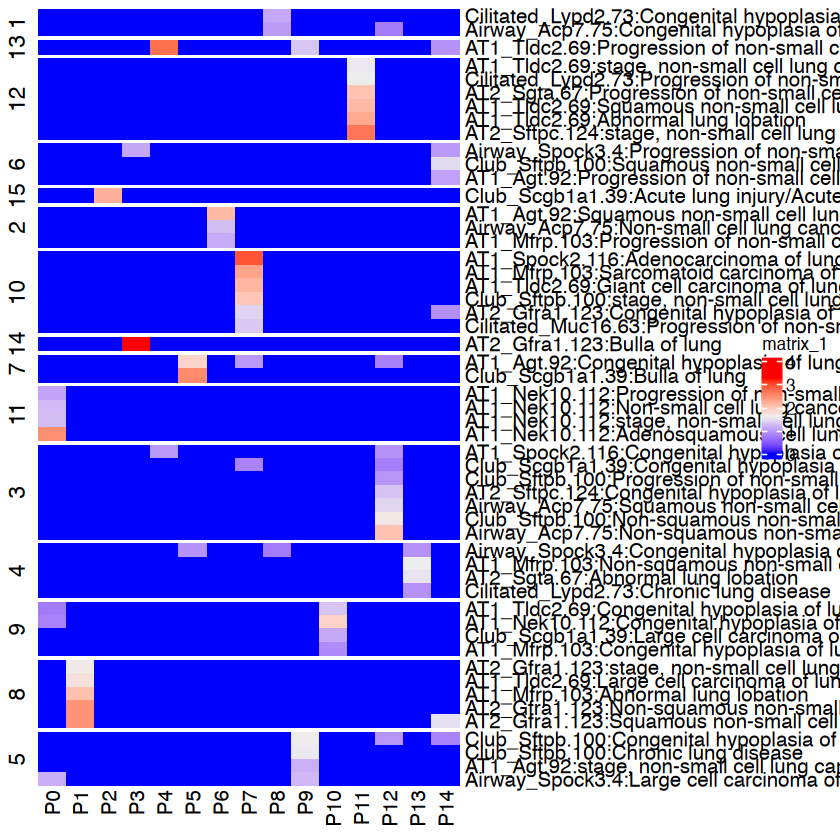

In [56]:
ht = Heatmap(tmp,
        cluster_rows=F, 
        cluster_columns=F,
        show_row_names=T,
        show_column_dend=F,
        show_row_dend = F,
        row_split = factor(stage[rownames(tmp)],c(1,13,12,6,15,2,10,14,7,11,3,4,9,8,5))
       )
draw(ht)

In [58]:
disease_order = rownames(tmp)[unlist(row_order(ht))]

In [61]:
tmp_lung_res_gene = lung_res %>%
    filter(pvalue<0.01,Count>5) %>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, new_name)
gene_list = sapply(tmp_lung_res_gene$geneID, function(x){
    background_gene_id[background_gene_id$ENTREZID%in%strsplit(x,'/')[[1]], 'SYMBOL']
})
names(gene_list) = paste0(tmp_lung_res_gene$new_name, ':',tmp_lung_res_gene$Description)

In [62]:
names(gene_list)

[1] "AT1_Mfrp.103:Abnormal lung lobation"                         
 [2] "AT2_Sgta.67:Abnormal lung lobation"                          
 [3] "Cilitated_Lypd2.73:Chronic lung disease"                     
 [4] "Club_Sftpb.100:Chronic lung disease"                         
 [5] "AT1_Agt.92:Congenital hypoplasia of lung"                    
 [6] "AT1_Agt.92:Congenital hypoplasia of lung"                    
 [7] "AT1_Agt.92:Congenital hypoplasia of lung"                    
 [8] "AT1_Mfrp.103:Congenital hypoplasia of lung"                  
 [9] "AT1_Nek10.112:Congenital hypoplasia of lung"                 
[10] "AT1_Nek10.112:Congenital hypoplasia of lung"                 
[11] "AT1_Spock2.116:Congenital hypoplasia of lung"                
[12] "AT1_Spock2.116:Congenital hypoplasia of lung"                
[13] "AT1_Tldc2.69:Congenital hypoplasia of lung"                  
[14] "AT1_Tldc2.69:Congenital hypoplasia of lung"                  
[15] "AT2_Gfra1.123:Congenital hypoplasia of lung"                 
[16] "AT2_Gfra1.123:Congenital hypoplasia of lung"                 
[17] "AT2_Sftpc.124:Congenital hypoplasia of lung"                 
[18] "Airway_Acp7.75:Congenital hypoplasia of lung"                
[19] "Airway_Acp7.75:Congenital hypoplasia of lung"                
[20] "Airway_Spock3.4:Congenital hypoplasia of lung"               
[21] "Airway_Spock3.4:Congenital hypoplasia of lung"               
[22] "Airway_Spock3.4:Congenital hypoplasia of lung"               
[23] "Cilitated_Lypd2.73:Congenital hypoplasia of lung"            
[24] "Club_Scgb1a1.39:Congenital hypoplasia of lung"               
[25] "Club_Scgb1a1.39:Congenital hypoplasia of lung"               
[26] "Club_Sftpb.100:Congenital hypoplasia of lung"                
[27] "Club_Sftpb.100:Congenital hypoplasia of lung"                
[28] "Club_Sftpb.100:Congenital hypoplasia of lung"                
[29] "AT1_Tldc2.69:Giant cell carcinoma of lung"                   
[30] "AT1_Tldc2.69:Large cell carcinoma of lung"                   
[31] "Airway_Spock3.4:Large cell carcinoma of lung"                
[32] "Airway_Spock3.4:Large cell carcinoma of lung"                
[33] "Club_Scgb1a1.39:Large cell carcinoma of lung"                
[34] "AT1_Nek10.112:Non-small cell lung cancer stage I"            
[35] "Airway_Acp7.75:Non-small cell lung cancer stage I"           
[36] "AT1_Mfrp.103:Non-squamous non-small cell lung cancer"        
[37] "Airway_Acp7.75:Non-squamous non-small cell lung cancer"      
[38] "Club_Sftpb.100:Non-squamous non-small cell lung cancer"      
[39] "AT1_Agt.92:Progression of non-small cell lung cancer"        
[40] "AT1_Mfrp.103:Progression of non-small cell lung cancer"      
[41] "AT1_Nek10.112:Progression of non-small cell lung cancer"     
[42] "AT1_Tldc2.69:Progression of non-small cell lung cancer"      
[43] "AT1_Tldc2.69:Progression of non-small cell lung cancer"      
[44] "AT2_Sgta.67:Progression of non-small cell lung cancer"       
[45] "Airway_Spock3.4:Progression of non-small cell lung cancer"   
[46] "Airway_Spock3.4:Progression of non-small cell lung cancer"   
[47] "Cilitated_Lypd2.73:Progression of non-small cell lung cancer"
[48] "Cilitated_Muc16.63:Progression of non-small cell lung cancer"
[49] "Club_Sftpb.100:Progression of non-small cell lung cancer"    
[50] "AT1_Agt.92:Squamous non-small cell lung cancer"              
[51] "AT2_Gfra1.123:Squamous non-small cell lung cancer"           
[52] "AT2_Gfra1.123:Squamous non-small cell lung cancer"           
[53] "Airway_Acp7.75:Squamous non-small cell lung cancer"          
[54] "Club_Sftpb.100:Squamous non-small cell lung cancer"          
[55] "AT1_Agt.92:stage, non-small cell lung cancer"                
[56] "AT1_Nek10.112:stage, non-small cell lung cancer"             
[57] "AT1_Tldc2.69:stage, non-small cell lung cancer"              
[58] "AT2_Gfra1.123:stage, non-small cell lung cancer"

In [206]:
gene_list['Airway_Cilitated_Muc16:Aplasia/Hypoplasia of the lungs']

$<NA>
NULL

In [63]:
length(unique(unlist(gene_list)))

[1] 290

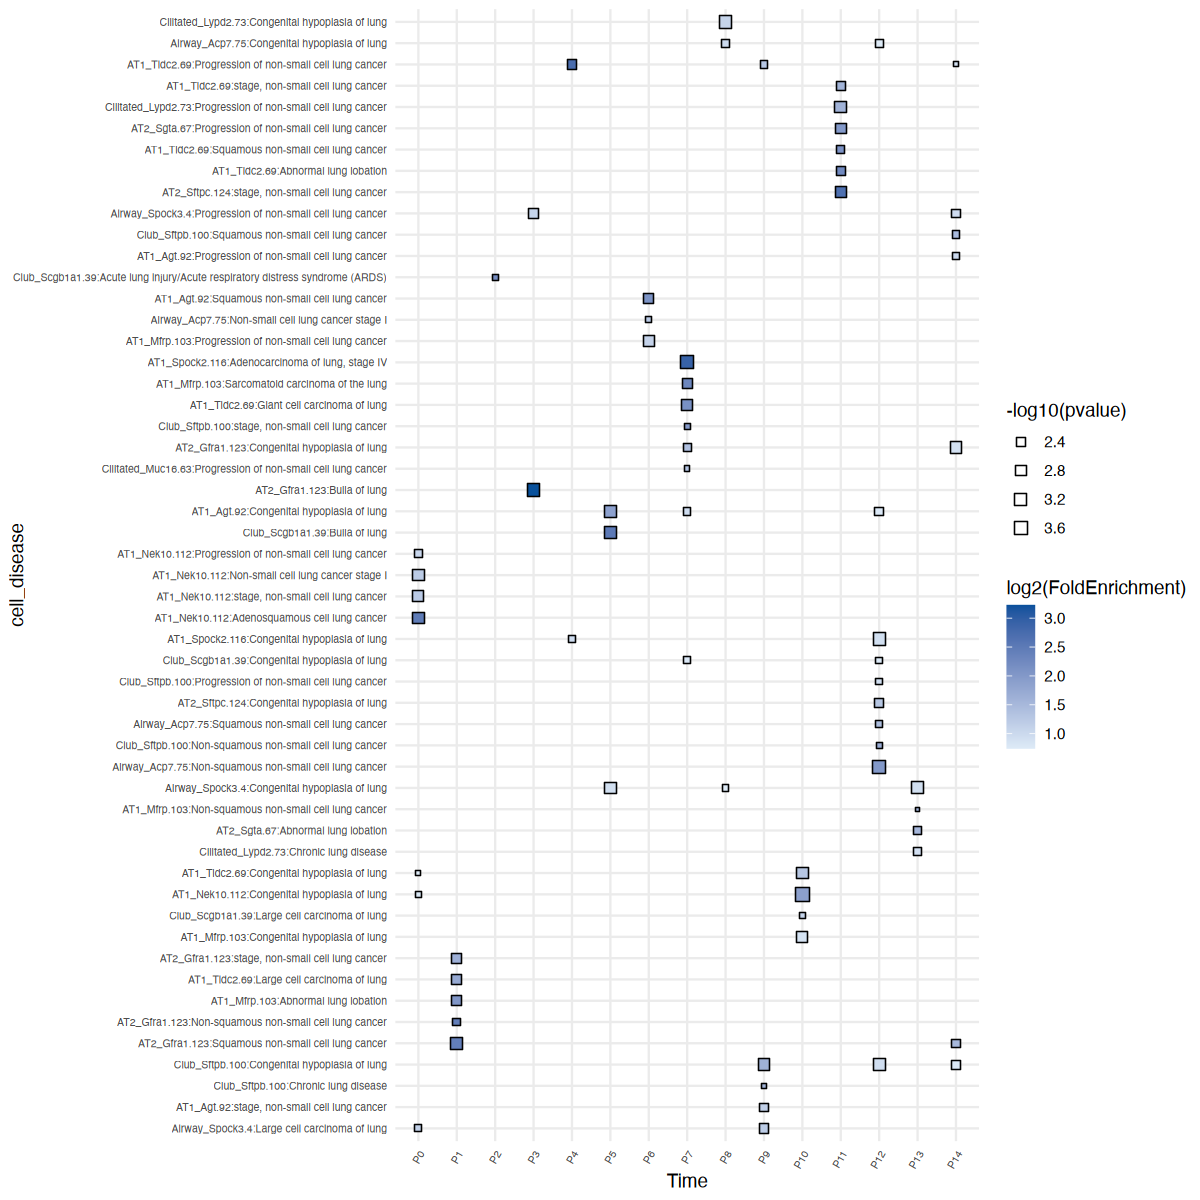

In [208]:
#keep_trait = all_trait_sq %>% filter(Time>0 , Celltype>0)
a=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, Celltype) %>%
    mutate(cell_disease=paste0(new_name,':', Description)) %>%
    mutate(cell_disease=factor(cell_disease, rev(disease_order))) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    ggplot(aes(x=Time, y=cell_disease,fill=log2(FoldEnrichment)))+
    #geom_tile(color='black', size=0.1)+
    geom_point(aes(size=-log10(pvalue)),shape=22)+
    #geom_point(aes(size=-log10(Coefficient_P_value)), shape=22, stroke=0.5)+
    #geom_tile()+
    scale_size_continuous(range = c(1,4))+
    #facet_wrap(~Trait, ncol=3)+
    #scale_fill_gradientn(colours = c("#08519c","#deebf7",'white', 'red', 'darkred'))+
    scale_fill_gradientn(colours = c("#deebf7","#08519c"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60, hjust=1, vjust=1),
          axis.text = element_text(size=6))

options(repr.plot.width=10, repr.plot.height=10)
a

In [209]:
ggsave(glue('{output_dir}/Epi_function2(cell and time dependent).pdf'), a,  
       width=180, height = 150, units='mm', dpi=600, bg='transparent')

In [210]:
head(lung_res)

ID       Description                                                 
C4534309 C4534309 Acute lung injury/Acute respiratory distress syndrome (ARDS)
C4524268 C4524268 Advanced lung cancer                                        
C0280217 C0280217 stage, non-small cell lung cancer                           
C4324656 C4324656 Non-squamous non-small cell lung cancer                     
C1737250 C1737250 Progression of non-small cell lung cancer                   
C0685695 C0685695 Abnormal lung lobation                                      
         GeneRatio BgRatio  RichFactor FoldEnrichment zScore   pvalue    
C4534309 2/422     12/13316 0.16666667 5.259084       2.670230 0.05360831
C4524268 4/422     54/13316 0.07407407 2.337371       1.781464 0.09133019
C0280217 5/422     78/13316 0.06410256 2.022725       1.638807 0.10124826
C4324656 2/422     20/13316 0.10000000 3.155450       1.745121 0.13101421
C1737250 5/422     89/13316 0.05617978 1.772725       1.323190 0.15187472
C0685695 2/422     27/13316 0.07407407 2.337371       1.258405 0.21038549
         p.adjust  qvalue    geneID                     Count cluster Celltype
C4534309 0.8084309 0.8084309 4780/8877                  2     AT1:P5  AT1     
C4524268 0.8084309 0.8084309 2113/4780/5291/7431        4     AT1:P5  AT1     
C0280217 0.8084309 0.8084309 2959/6240/356/153090/7431  5     AT1:P5  AT1     
C4324656 0.8084309 0.8084309 5291/7431                  2     AT1:P5  AT1     
C1737250 0.8084309 0.8084309 3608/11186/23368/4780/2254 5     AT1:P5  AT1     
C0685695 0.8084309 0.8084309 23426/340419               2     AT1:P5  AT1     
         Time new_name      
C4534309 P5   AT1_Spock2.116
C4524268 P5   AT1_Spock2.116
C0280217 P5   AT1_Spock2.116
C4324656 P5   AT1_Spock2.116
C1737250 P5   AT1_Spock2.116
C0685695 P5   AT1_Spock2.116

In [64]:
library(ggbeeswarm)
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')

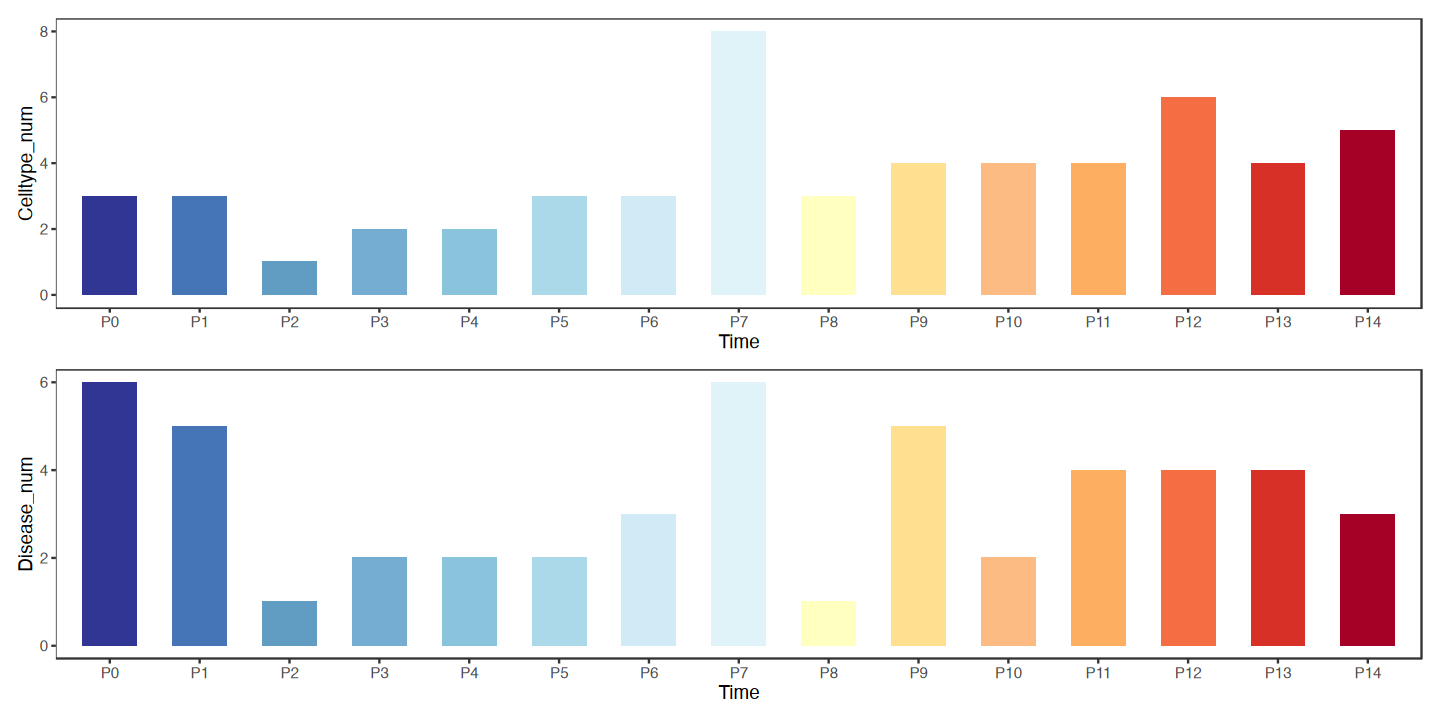

In [69]:
# number of cell types affected by diseases at each time point
options(repr.plot.width=12, repr.plot.height=6)
a_top=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, Celltype) %>%
    group_by(Time) %>%
    summarise(n=length(unique(new_name))) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    ggplot(aes(x=Time,y=n, fill=Time))+
    geom_bar(stat='identity', width=0.6)+
    scale_fill_manual(values = time_color2)+
    labs(y='Celltype_num')+
    theme_bw()+
    theme(legend.position = 'none', panel.grid = element_blank())

# number of cell types affected by diseases at each time point
options(repr.plot.width=12, repr.plot.height=6)
b_top=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Time)))%>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, Celltype) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    ggplot(aes(x=Time, fill=Time))+
    geom_bar(stat='count', width=0.6)+
    scale_fill_manual(values = time_color2)+
    labs(y='Disease_num')+
    theme_bw()+
    theme(legend.position = 'none', panel.grid = element_blank())
a_top/b_top
ggsave(glue('{output_dir}/Epi_function2(cell and time dependent-count time points).pdf'), a_top/b_top,  
       width=6, height = 4, units='in', dpi=600, bg='transparent')

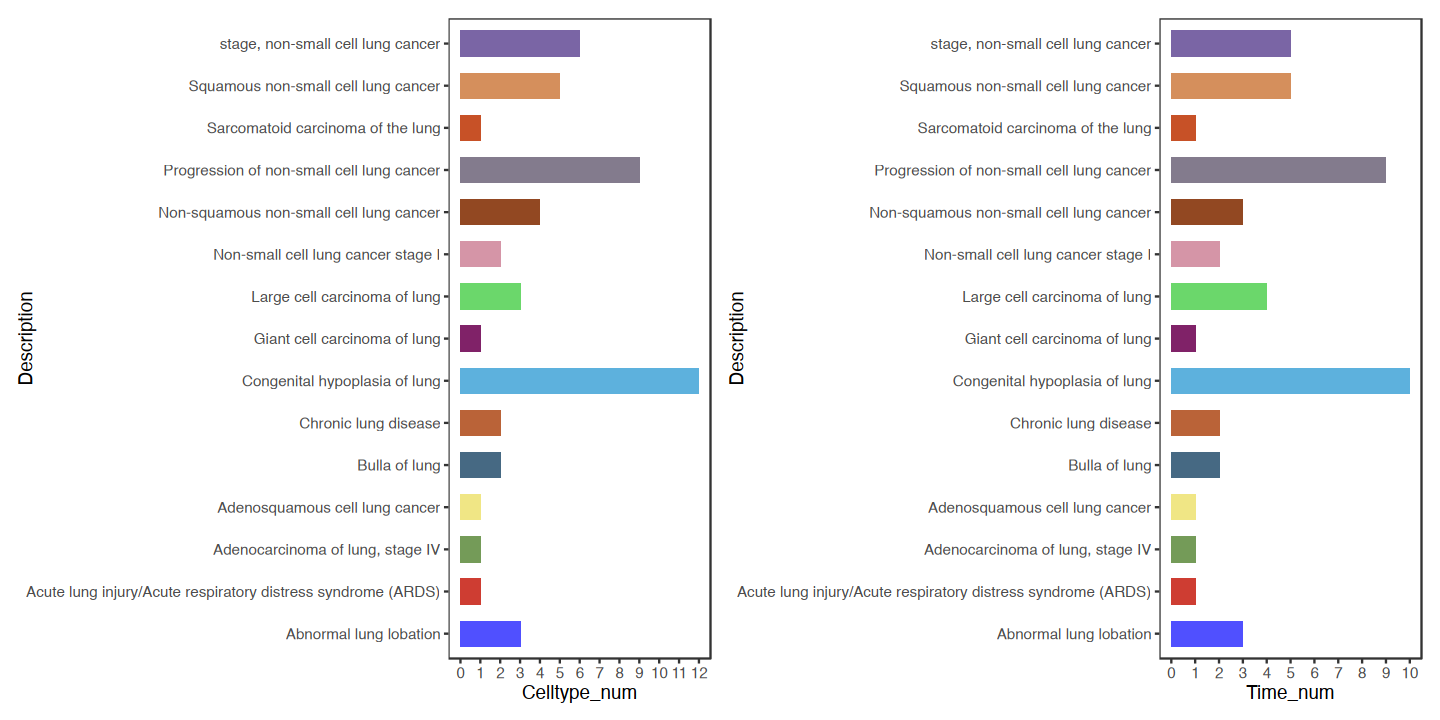

In [58]:
# number of cells affected per disease
options(repr.plot.width=12, repr.plot.height=6)
a_right=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Celltype)))%>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, Celltype) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    ggplot(aes(x=Description, fill=Description))+
    geom_bar(stat='count', width=0.6)+
    scale_fill_igv()+
    scale_y_continuous(breaks=0:12)+
    labs(y='Celltype_num')+
    theme_bw()+coord_flip()+
    theme(legend.position = 'none', panel.grid = element_blank())

# number of time points affected per disease
options(repr.plot.width=12, repr.plot.height=6)
b_right=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Time)))%>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, Celltype) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    ggplot(aes(x=Description, fill=Description))+
    geom_bar(stat='count', width=0.6)+
    scale_fill_igv()+
      scale_y_continuous(breaks=0:12)+
    labs(y='Time_num')+
    theme_bw()+coord_flip()+
    theme(legend.position = 'none', panel.grid = element_blank())
a_right+b_right
ggsave(glue('{output_dir}/Epi_function2(cell and time dependent-count diseases).pdf'), a_right+b_right,  
       width=10, height = 4, units='in', dpi=600, bg='transparent')

In [98]:
xx=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Celltype)))%>%
    group_by(Description) %>%
    summarise(num=length(unique(Celltype))) %>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(num)


In [99]:
length(unique(lung_res$Celltype))

[1] 14

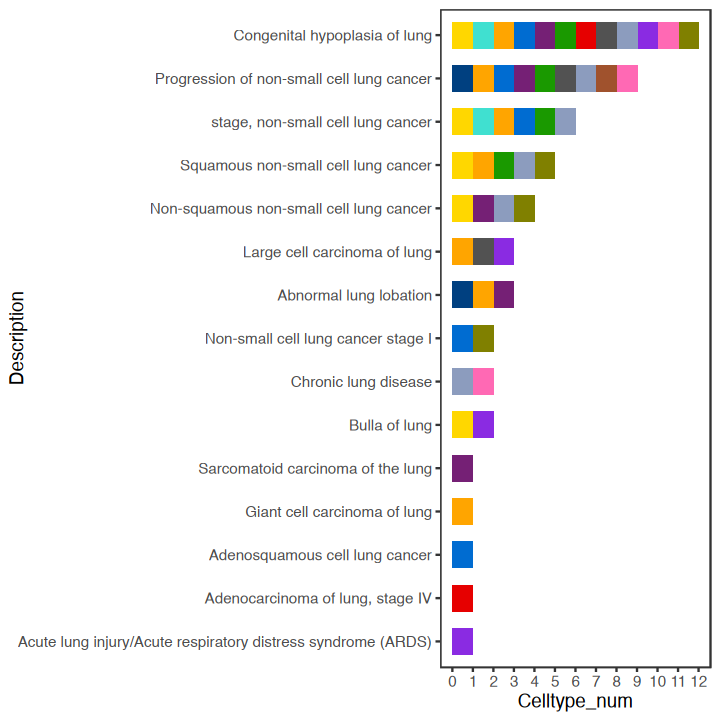

In [100]:
a_right=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Celltype)))%>%
    #filter(Description%in%keep_trait$label) %>%
    mutate(Description=factor(Description, xx$Description)) %>%
    ggplot(aes(x=Description, fill=Celltype))+
    geom_bar(stat='count', width=0.6)+
    scale_fill_manual(values = tmp_curr_celltype_color)+
    scale_y_continuous(breaks=0:12)+
    labs(y='Celltype_num')+
    theme_bw()+coord_flip()+
    theme(legend.position = 'none', panel.grid = element_blank())
options(repr.plot.width=6, repr.plot.height=6)
a_right

`summarise()` has grouped output by 'Celltype'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'Celltype'. You can override using the `.groups` argument.


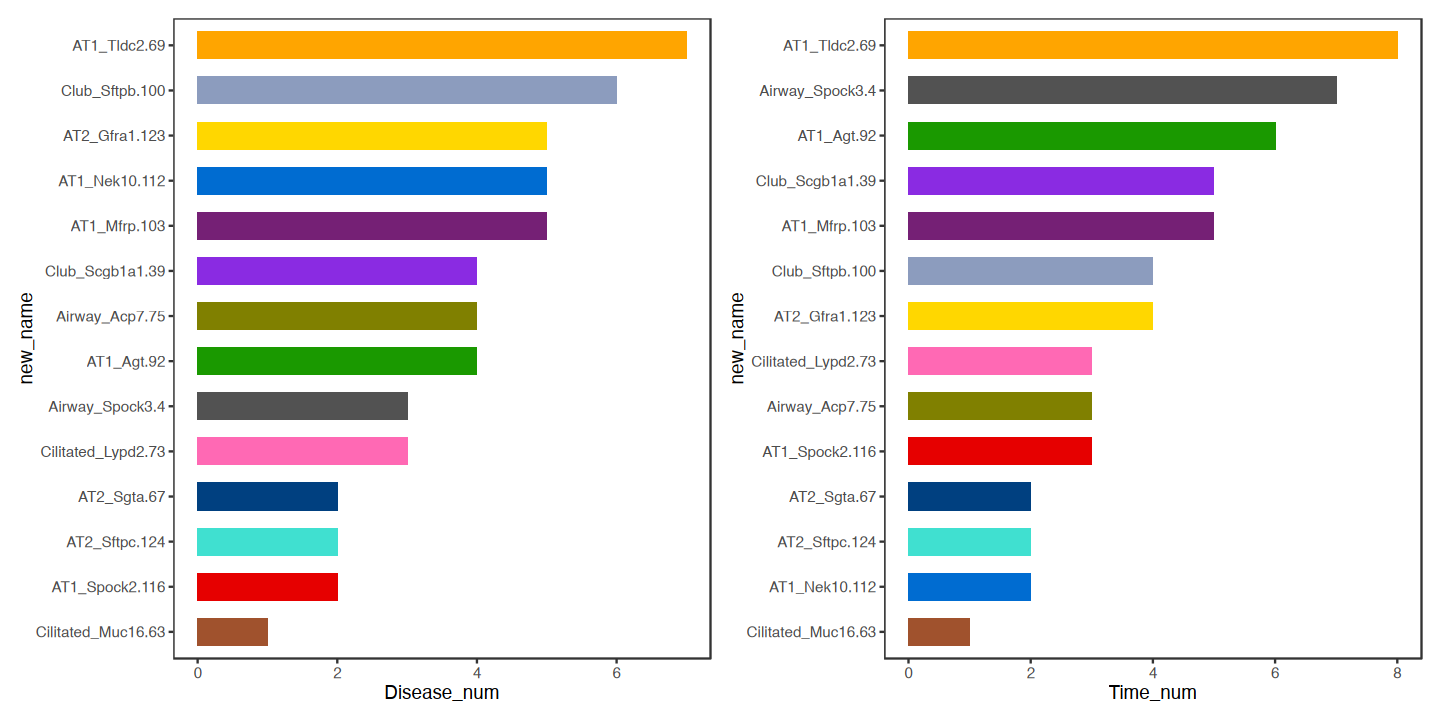

In [103]:
# number of cells affected per disease
options(repr.plot.width=12, repr.plot.height=6)
a=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Celltype)))%>%
    group_by(Celltype,new_name) %>%
    summarise(num=length(unique(Description))) %>%
    as.data.frame() %>%
    arrange(num) %>%
    mutate(new_name=factor(new_name, new_name)) %>%
    ggplot(aes(x=new_name, y=num, fill=new_name))+
    geom_bar(stat='identity', width=0.6)+
    scale_fill_manual(values = tmp_curr_celltype_color2)+
    labs(y='Disease_num')+
    theme_bw()+coord_flip()+
    theme(legend.position = 'none', panel.grid = element_blank())

# number of time points affected per disease
options(repr.plot.width=12, repr.plot.height=6)
b=lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    filter(!duplicated(paste0(Description, Celltype, Time)))%>%
    group_by(Celltype,new_name) %>%
    summarise(num=length(unique(Time))) %>%
    as.data.frame() %>%
    arrange(num) %>%
    mutate(new_name=factor(new_name, new_name)) %>%
    ggplot(aes(x=new_name, y=num, fill=new_name))+
    geom_bar(stat='identity', width=0.6)+
    scale_fill_manual(values = tmp_curr_celltype_color2)+
    labs(y='Time_num')+
    theme_bw()+coord_flip()+
    theme(legend.position = 'none', panel.grid = element_blank())
a+b
ggsave(glue('{output_dir}/Epi_function2(cell and time dependent-count cell types).pdf'), a+b,  
       width=10, height = 4, units='in', dpi=600, bg='transparent')

In [104]:
library(scatterpie)

scatterpie v0.2.6 Learn more at https://yulab-smu.top/




Attaching package: 'scatterpie'


The following object is masked from 'package:sp':

    recenter




In [110]:
pie_data = lung_res %>%
    filter(pvalue<0.01,Count>3) %>%
    #filter(Description%in%keep_trait$label) %>%
    arrange(Description, new_name) %>%
    dcast(Description+Time~new_name, value.var = 'Count', fill=0) 
pie_data_cols = colnames(pie_data)[-(1:2)]
pie_data$group = 1:nrow(pie_data)

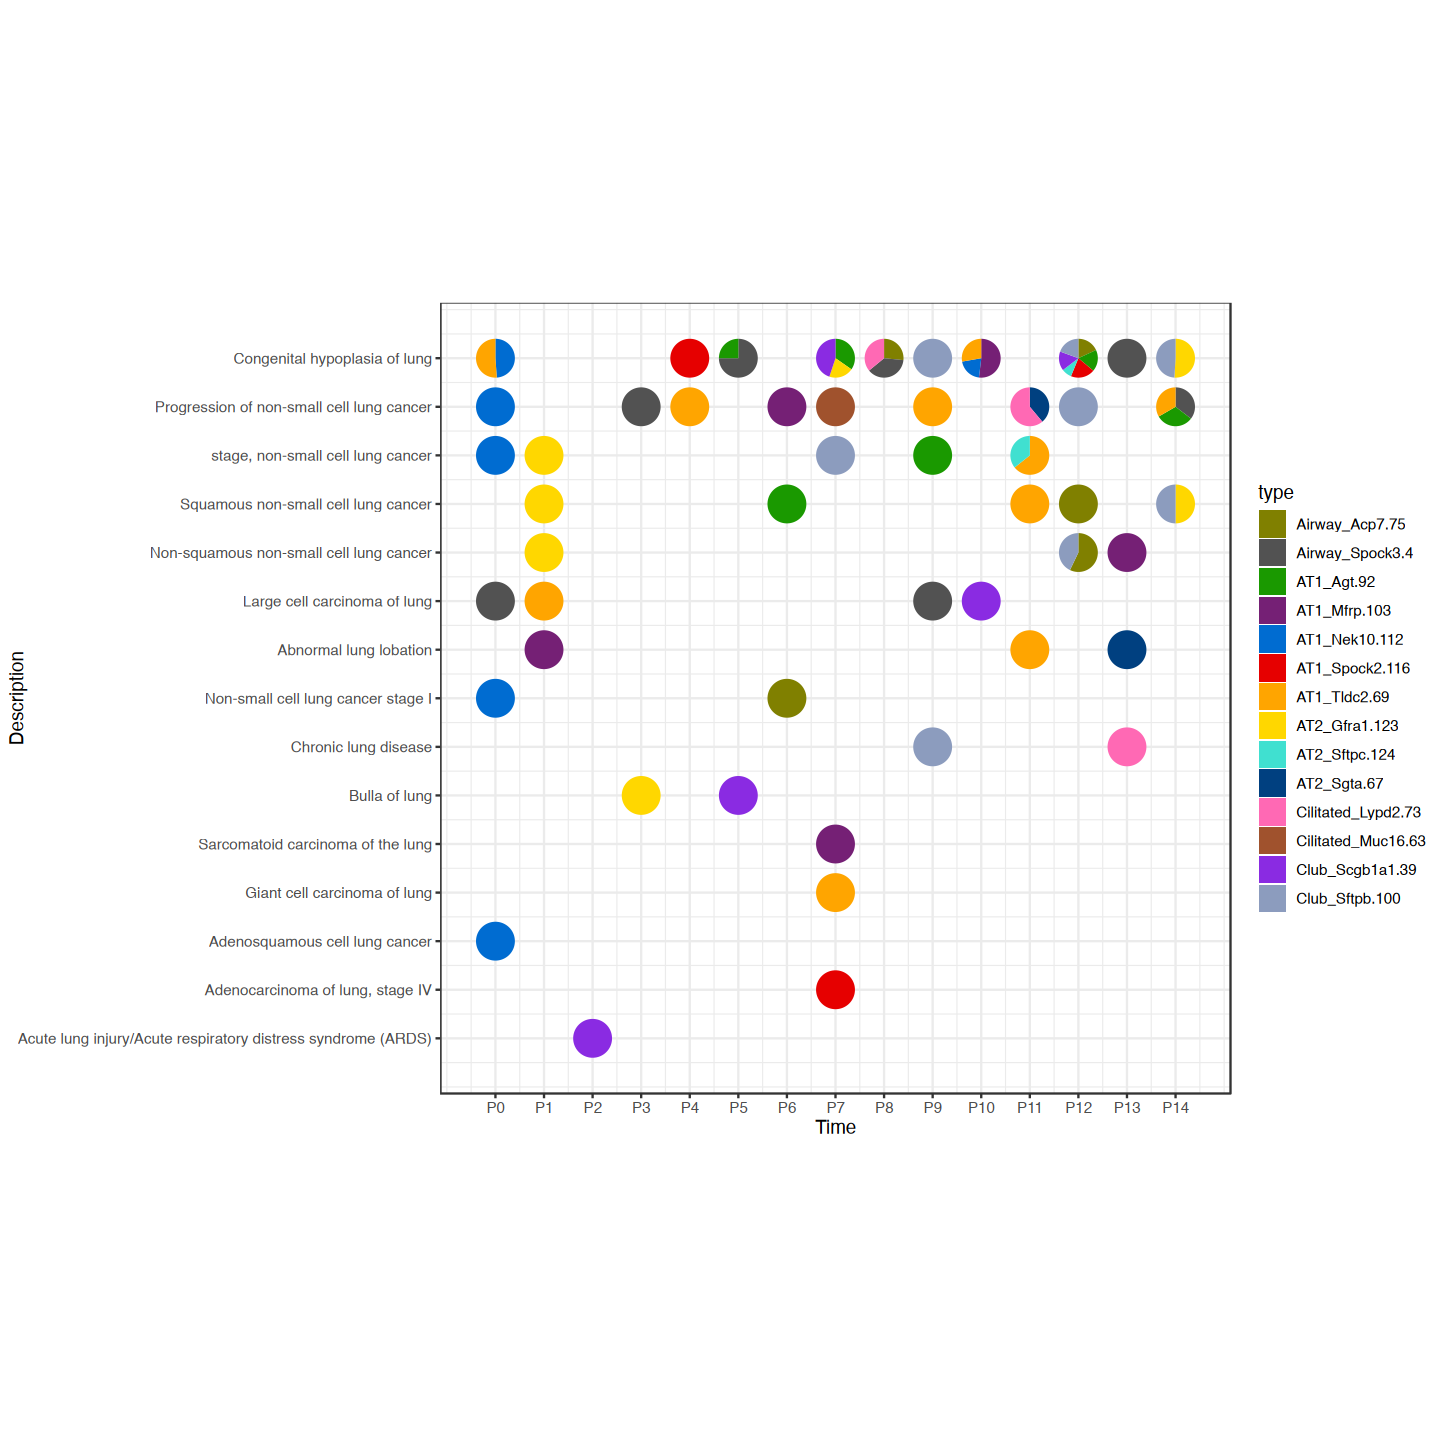

In [112]:
options(repr.plot.width=12, repr.plot.height=12)
a2=pie_data %>%
    mutate(Description=factor(Description, xx$Description)) %>%
    mutate(Time=factor(Time, time_levels)) %>%
    mutate(Time=as.numeric(Time)) %>%
    mutate(Description=as.numeric(Description)) %>%
    ggplot(aes(x=Time, y=Description))+
    geom_scatterpie(
        aes(x=Time, y=Description,group=group, r=0.4),   # r = radius
        cols=pie_data_cols, color=NA
    ) +
    coord_equal()+
    scale_x_continuous(breaks=1:15, labels = time_levels)+
    scale_y_continuous(breaks=1:length(unique(xx$Description)), labels = xx$Description)+
    scale_fill_manual(values = tmp_curr_celltype_color2)+
    # #scale_fill_igv()+
    theme_bw()
a2

## samecell、sametime、differentdisease

In [372]:
library(igraph)
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')


Attaching package: 'igraph'


The following object is masked from 'package:clusterProfiler':

    simplify


The following objects are masked from 'package:rtracklayer':

    blocks, path


The following object is masked from 'package:BiocIO':

    path


The following object is masked from 'package:Biostrings':

    union


The following object is masked from 'package:XVector':

    path


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:gtools':

    permute


The following objects are masked from 'package:purrr':

    compose, simplify


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following object is masked from 'package:GenomicRanges':

    union


The following object is masked from 'package:IRanges':

    union


The following object is masked from 'package:S4Vectors':

    union


The following objects are masked from 'package:BiocGenerics':

    normalize, path, 

In [373]:
tmp_lung_res0 =lung_res%>% filter(pvalue<0.01,Count>3) %>% mutate(Celltype = new_name) 

ERROR: Error: object 'lung_res' not found


In [827]:
write.table(tmp_lung_res0, glue('{output_dir}/Lung_enrich.txt'), quote=F, sep='\t')

In [378]:
tmp_lung_res0 = read.table(glue('{output_dir}/Lung_enrich.txt'), header=T, sep='\t')

In [ ]:
tmp_lung_res0_P7 = tmp_lung_res0 %>% filter(Time=='P7')

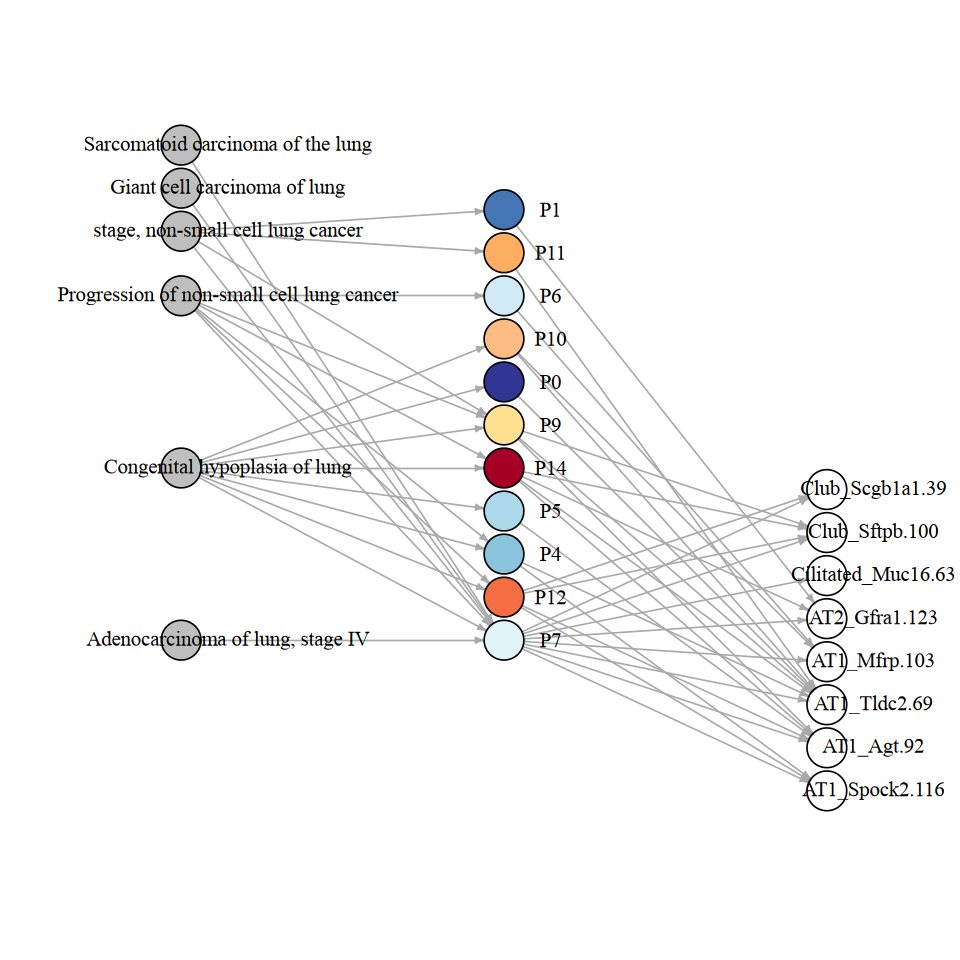

In [388]:
options(repr.plot.width=8, repr.plot.height=8)
#tmp_time = unlist(mult_dis[mult_dis$Celltype==tmp_celltype, 'Time'])

tmp_lung_res = tmp_lung_res0 %>% filter(Description%in%tmp_lung_res0_P7$Description, Celltype%in%tmp_lung_res0_P7$Celltype) 
#tmp_lung_res$Time = paste0(tmp_lung_res$Time, tmp_lung_res$Celltype)
#other_time = setdiff(time_levels,unique(tmp_lung_res$Time))
#tmp_net = data.frame('Celltype'=tmp_celltype, 'Time'=other_time)

net_work_data = as.matrix(tmp_lung_res[,c('Description', 'Time')])
net_work_data = rbind(net_work_data, as.matrix(tmp_lung_res[,c('Time', 'Celltype')]))
net_work_data = as.data.frame(net_work_data)
#net_work_data = rbind(net_work_data, tmp_net)
net_work_data = net_work_data %>% unique()

g <- graph_from_data_frame(net_work_data , directed = T)


nodes_color = sapply(names(V(g)), function(x){
    if(x %in% net_work_data$Time){
        return(time_color2[x])
    }else if(x %in% net_work_data$Celltype){
        return(tmp_curr_celltype_color2[x])
    }else{
        return('gray')
    }
})
nodes_size = sapply(names(V(g)), function(x){
    if(x %in% tmp_lung_res$Time){
        return(12)
    }else if(x %in% tmp_lung_res$Celltype){
        return(12)
    }else{
        return(12)
    }
})

set.seed(1234)
#g_order = c(tmp_celltype, time_levels, unique(tmp_lung_res$Description))
#    order_idx = match(g_order, V(g)$name)

ly = layout_as_tree(g)#[order_idx,]
ly_roate = cbind(-ly[,2], ly[,1])
plot(g, edge.arrow.size = 0.3, vertex.color = nodes_color, vertex.label.color = "black",
    vertex.size=nodes_size,
        vertex.label.dist=2, 
        vertex.label.degree=0,
        layout=ly_roate)#

In [390]:
write.table(net_work_data, glue('{output_dir}/Lung_enrich_network.txt'), quote=F, sep='\t', row.names=F, col.names=T)

In [386]:
pdf(glue('{output_dir}/P7relationship network.pdf'), width=12, height=6)

options(repr.plot.width=12, repr.plot.height=10)
plot(g, edge.arrow.size = 0.3, vertex.color = nodes_color, vertex.label.color = "black",
    vertex.size=nodes_size,
        vertex.label.dist=2, 
        vertex.label.degree=0,
        layout=ly_roate)#

dev.off()

pdf 
  2

`summarise()` has grouped output by 'Celltype'. You can override using the
`.groups` argument.


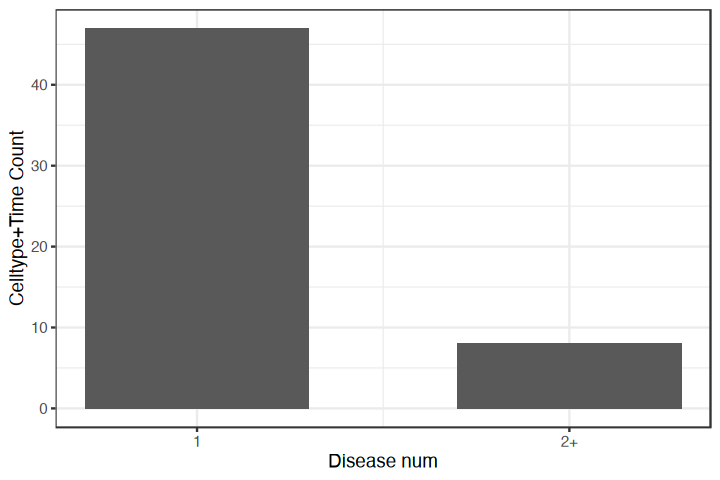

In [247]:
options(repr.plot.width=6, repr.plot.height=4)
a=tmp_lung_res0 %>%
    group_by(Celltype, Time) %>%
    dplyr::summarise(num=n()) %>%
    mutate(num = ifelse(num>2, 2, num)) %>%
    ggplot(aes(x=num))+
    geom_bar(stat='count', width=0.6)+
    scale_x_continuous(breaks = c(1,2), labels = c(1,'2+'))+
    labs(x='Disease num', y='Celltype+Time Count')+
    theme_bw()
a
ggsave(glue('{output_dir}/Epi_function(sameCsameTdifferentD).pdf'), a,  
       width=40, height = 50, units='mm', dpi=600, bg='transparent')

In [248]:
# affect multiple diseases
mult_dis = tmp_lung_res0 %>%
    group_by(Celltype, Time) %>%
    dplyr::summarise(num=n()) #%>% 
    #filter(num>1)

`summarise()` has grouped output by 'Celltype'. You can override using the
`.groups` argument.


In [233]:
pdf(glue('{output_dir}/sameCsameTdifferentDrelationship network.pdf'), width=12, height=6)

options(repr.plot.width=12, repr.plot.height=10)
par(mfrow=c(2,4))
for(tmp_celltype in unique(mult_dis$Celltype)){
    # tmp_celltype = as.character(mult_dis[i, 'Celltype'])
    tmp_time = unlist(mult_dis[mult_dis$Celltype==tmp_celltype, 'Time'])
    
    tmp_lung_res = tmp_lung_res0 %>% filter(Celltype==tmp_celltype, Time%in%tmp_time) 
    #other_time = setdiff(time_levels,unique(tmp_lung_res$Time))
    #tmp_net = data.frame('Celltype'=tmp_celltype, 'Time'=other_time)

    net_work_data = as.matrix(tmp_lung_res[,c('Celltype', 'Time')])
    net_work_data = rbind(net_work_data, as.matrix(tmp_lung_res[,c('Time', 'Description')]))
    net_work_data = as.data.frame(net_work_data)
    #net_work_data = rbind(net_work_data, tmp_net)
    net_work_data = net_work_data %>% unique()

    g <- graph_from_data_frame(net_work_data , directed = T)


    nodes_color = sapply(names(V(g)), function(x){
        if(x %in% net_work_data$Time){
            return(time_color2[x])
        }else if(x %in% net_work_data$Celltype){
            return(tmp_curr_celltype_color2[x])
        }else{
            return('gray')
        }
    })
    nodes_size = sapply(names(V(g)), function(x){
        if(x %in% tmp_lung_res$Time){
            return(12)
        }else if(x %in% tmp_lung_res$Celltype){
            return(18)
        }else{
            return(6)
        }
    })

    set.seed(1234)
    #g_order = c(tmp_celltype, time_levels, unique(tmp_lung_res$Description))
    #    order_idx = match(g_order, V(g)$name)

    ly = layout_as_tree(g)#[order_idx,]
    ly_roate = cbind(-ly[,2], ly[,1])
    plot(g, edge.arrow.size = 0.3, vertex.color = nodes_color, vertex.label.color = "black",
        vertex.size=nodes_size,
         vertex.label.dist=2, 
         vertex.label.degree=0,
         layout=ly_roate)
}

dev.off()

agg_record_469344150 
                   2

In [439]:
# example

In [ ]:
celltye_time_disease_genes_1 = list()

for(k in 1:nrow(mult_dis)){
    tc = mult_dis$Celltype[k]
    tt = mult_dis$Time[k]
    tmp_lung_res = tmp_lung_res0 %>% filter(Celltype==tc, Time==tt) 

    tmp_same_gene = NULL
    tmp_unique_gene = list()
    for(j in tmp_lung_res$Description){
        i = tmp_lung_res[tmp_lung_res$Description==j, 'geneID']
        tmp_gene = strsplit(i, '/')[[1]]
        if(is.null(tmp_same_gene)){
            tmp_same_gene = tmp_gene
        }else{
            tmp_same_gene = intersect(tmp_same_gene, tmp_gene)
        }
        tmp_unique_gene[[j]] = tmp_gene

    }
    tmp_unique_gene_name = list()
    for(i in names(tmp_unique_gene)){
        tmp_gene = setdiff(tmp_unique_gene[[i]], tmp_same_gene)
        tmpgene_id = bitr(tmp_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
        tmp_unique_gene_name[[i]] = tmpgene_id$SYMBOL
    }
    #tmp_unique_gene_name

    tmpgene_id = bitr(tmp_same_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
    #tmpgene_id$SYMBOL
    celltye_time_disease_genes_1[[paste0(tc,':',tt)]] = list('unique'=tmp_unique_gene_name,
                                                             'same'=tmpgene_id$SYMBOL)
}


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' ret

In [252]:
celltye_time_disease_genes_1[['AT1_Nek10.112:P0']]

$unique
$unique$`Adenosquamous cell lung cancer`
[1] "ERBB2" "KRAS"  "RET"   "KIF5B"

$unique$`Non-small cell lung cancer stage I`
 [1] "SLC1A5" "S100A6" "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CDH13" 
 [9] "FHIT"   "FOXA2"  "HIF1A"  "EPHA2"  "DCLK1"  "EFNA1"  "RARB"  

$unique$`stage, non-small cell lung cancer`
 [1] "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CUX1"   "HIF1A"  "KRAS"  
 [9] "RET"    "NOS3"   "BTG2"   "MAPK3"  "DAB2IP" "CCND1" 

$unique$`Progression of non-small cell lung cancer`
 [1] "MDM2"   "FAM83F" "LATS2"  "CDK14"  "HIF1A"  "TMPO"   "EPHA2"  "PIK3R1"
 [9] "SMAD7"  "IL6R"   "FOXN1"  "HOPX"   "SMAD3"  "TOPORS"

$unique$`Congenital hypoplasia of lung`
 [1] "KAT6B"  "CRB2"   "NDST1"  "HSPG2"  "SFTPB"  "VEGFA"  "NOTCH2" "SETBP1"
 [9] "FOXA2"  "COL2A1" "KRAS"   "RET"    "PRKCA"  "IFT80"  "FRAS1"  "LMNA"  
[17] "LIFR"   "NFIA"   "CCND1"  "ITGA3"  "RARB"  


$same
[1] "EGFR"

## samecell、differenttime、samedisease

`summarise()` has grouped output by 'Celltype'. You can override using the `.groups` argument.


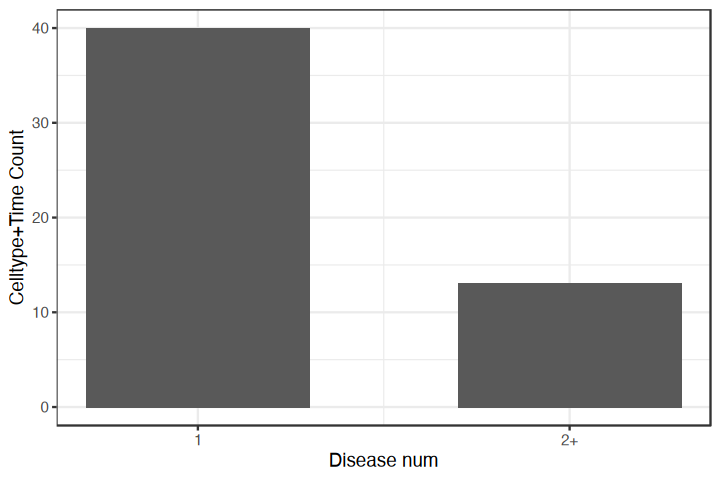

In [442]:
options(repr.plot.width=6, repr.plot.height=4)
a=tmp_lung_res0 %>%
    group_by(Celltype, Description) %>%
    dplyr::summarise(num=n()) %>%
    mutate(num = ifelse(num>2, 2, num)) %>%
    ggplot(aes(x=num))+
    geom_bar(stat='count', width=0.6)+
    scale_x_continuous(breaks = c(1,2), labels = c(1,'2+'))+
    labs(x='Disease num', y='Celltype+Time Count')+
    theme_bw()
a
ggsave(glue('{output_dir}/Epi_function(sameCdifferentTsameD).pdf'), a,  
       width=40, height = 50, units='mm', dpi=600, bg='transparent')

In [443]:
# affect single disease
single_dis = tmp_lung_res0 %>%
    group_by(Celltype, Description) %>%
    dplyr::summarise(num=n()) %>% 
    filter(num>1)

`summarise()` has grouped output by 'Celltype'. You can override using the `.groups` argument.


In [444]:
single_dis

Celltype            Description                               num
1  AT1                 Congenital hypoplasia of lung             2  
2  AT1_Agt             Congenital hypoplasia of lung             3  
3  AT1_Nek10           Congenital hypoplasia of lung             2  
4  AT1_Tldc2           Congenital hypoplasia of lung             2  
5  AT1_Tldc2           Progression of non-small cell lung cancer 3  
6  AT2_Gfra1           Congenital hypoplasia of lung             2  
7  AT2_Gfra1           Squamous non-small cell lung cancer       2  
8  Airway_Acp7         Congenital hypoplasia of lung             2  
9  Airway_Club_Scgb1a1 Congenital hypoplasia of lung             2  
10 Airway_Club_Sftpb   Congenital hypoplasia of lung             3  
11 Airway_Spock3       Congenital hypoplasia of lung             3  
12 Airway_Spock3       Large cell carcinoma of lung              2  
13 Airway_Spock3       Progression of non-small cell lung cancer 2

In [445]:
pdf(glue('{output_dir}/sameCdifferentTsameDrelationship network.pdf'), width=12, height=6)
options(repr.plot.width=12, repr.plot.height=10)
par(mfrow=c(2,4))
for(tmp_celltype in unique(single_dis$Celltype)){

    # tmp_celltype = as.character(mult_dis[i, 'Celltype'])
    tmp_time = unlist(single_dis[single_dis$Celltype==tmp_celltype, 'Description'])
    #tmp_celltype='AT1_Tldc2'
    #tmp_time = 'stage, non-small cell lung cancer'
    tmp_lung_res = tmp_lung_res0 %>% filter(Celltype==tmp_celltype, Description%in%tmp_time) 
    #other_time = setdiff(time_levels,unique(tmp_lung_res$Time))
    #tmp_net = data.frame('Celltype'=tmp_celltype, 'Time'=other_time)
    #print(tmp_lung_res)
    net_work_data = as.matrix(tmp_lung_res[,c('Celltype', 'Time')])
    net_work_data = rbind(net_work_data, as.matrix(tmp_lung_res[,c('Time', 'Description')]))
    net_work_data = as.data.frame(net_work_data)
    #net_work_data = rbind(net_work_data, tmp_net)
    net_work_data = net_work_data %>% unique()

    g <- graph_from_data_frame(net_work_data , directed = T)


    nodes_color = sapply(names(V(g)), function(x){
        if(x %in% net_work_data$Time){
            return(time_color2[x])
        }else if(x %in% net_work_data$Celltype){
            return(round4_color[x])
        }else{
            return('gray')
        }
    })
    nodes_size = sapply(names(V(g)), function(x){
        if(x %in% tmp_lung_res$Time){
            return(12)
        }else if(x %in% tmp_lung_res$Celltype){
            return(18)
        }else{
            return(6)
        }
    })

    set.seed(1234)
    #g_order = c(tmp_celltype, time_levels, unique(tmp_lung_res$Description))
    #    order_idx = match(g_order, V(g)$name)

    ly = layout_as_tree(g)#[order_idx,]
    ly_roate = cbind(-ly[,2], ly[,1])
    plot(g, edge.arrow.size = 0.3, vertex.color = nodes_color, vertex.label.color = "black",
        vertex.size=nodes_size,
         vertex.label.dist=2, 
         vertex.label.degree=0,
         layout=ly_roate)
}
dev.off()

pdf 
  2

In [446]:
celltye_time_disease_genes_2 = list()

for(k in 1:nrow(single_dis)){
    tc = single_dis$Celltype[k]
    tt = single_dis$Description[k]
    tmp_lung_res = tmp_lung_res0 %>% filter(Celltype==tc, Description==tt) 

    tmp_same_gene = NULL
    tmp_unique_gene = list()
    for(j in tmp_lung_res$Time){
        i = tmp_lung_res[tmp_lung_res$Time==j, 'geneID']
        tmp_gene = strsplit(i, '/')[[1]]
        tmp_gene = bitr(tmp_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
        tmp_gene = tmp_gene$SYMBOL
        #tmp_gene = intersect(tmp_gene, cluster_top_genes2[[paste0(tc,':',j)]])
        if(is.null(tmp_same_gene)){
            tmp_same_gene = tmp_gene
        }else{
            tmp_same_gene = intersect(tmp_same_gene, tmp_gene)
        }
        tmp_unique_gene[[j]] = tmp_gene

    }
#     tmp_unique_gene_name = list()
#     for(i in names(tmp_unique_gene)){
#         tmp_gene = setdiff(tmp_unique_gene[[i]], tmp_same_gene)
        
#         tmp_unique_gene_name[[i]] = tmpgene_id$SYMBOL
#     }
    #tmp_unique_gene_name

    # tmpgene_id = bitr(tmp_same_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
    #tmpgene_id$SYMBOL
    celltye_time_disease_genes_2[[paste0(tc,':',tt)]] = list('unique'=tmp_unique_gene,
                                                             'same'=tmp_same_gene)
}


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' ret

In [312]:
celltye_time_disease_genes_2

$`AT1:Congenital hypoplasia of lung`
$`AT1:Congenital hypoplasia of lung`$unique
$`AT1:Congenital hypoplasia of lung`$unique$P8
[1] "PRKCA"

$`AT1:Congenital hypoplasia of lung`$unique$P10
character(0)


$`AT1:Congenital hypoplasia of lung`$same
character(0)


$`AT1:Squamous cell carcinoma of lung`
$`AT1:Squamous cell carcinoma of lung`$unique
$`AT1:Squamous cell carcinoma of lung`$unique$P13
[1] "FHIT"

$`AT1:Squamous cell carcinoma of lung`$unique$P10
character(0)


$`AT1:Squamous cell carcinoma of lung`$same
NULL


$`AT1_Agt:Congenital hypoplasia of lung`
$`AT1_Agt:Congenital hypoplasia of lung`$unique
$`AT1_Agt:Congenital hypoplasia of lung`$unique$P14
[1] "PRKCA"  "SETBP1"

$`AT1_Agt:Congenital hypoplasia of lung`$unique$P4
[1] "FOXA2"  "AGT"    "PIK3CB" "FRAS1"  "VEGFA"  "PRKCA"  "EGFR"   "NDST1" 


$`AT1_Agt:Congenital hypoplasia of lung`$same
[1] "PRKCA"


$`AT1_Agt:Squamous cell carcinoma of lung`
$`AT1_Agt:Squamous cell carcinoma of lung`$unique
$`AT1_Agt:Squamous cell carcinoma of lung`$unique$P10
 [1] "RBMS3"    "FRY"      "SPARC"    "DLC1"     "DOCK8"    "LCORL"   
 [7] "FGFR2"    "CACNA2D3" "BDNF"     "UVRAG"    "MYO10"    "FHIT"    
[13] "IFIT2"    "MAP2K4"   "IGF1R"    "WNK1"     "DDR1"     "PIK3CB"  
[19] "RAD51B"   "VEGFA"    "FOXA2"    "EGFR"     "THRB"    

$`AT1_Agt:Squamous cell carcinoma of lung`$unique$P4
 [1] "IGF1R"  "RBMS3"  "FRY"    "BTBD9"  "SPARC"  "FOXA2"  "DOCK8"  "LCORL" 
 [9] "PIK3CB" "MYO10"  "FGFR2"  "MAPK8"  "VEGFA"  "EGFR"   "FYN"    "PDPN"  


$`AT1_Agt:Squamous cell carcinoma of lung`$same
 [1] "RBMS3"  "FRY"    "SPARC"  "DOCK8"  "LCORL"  "FGFR2"  "MYO10"  "IGF1R" 
 [9] "PIK3CB" "VEGFA"  "FOXA2"  "EGFR"  


$`AT1_Mfrp:Adenocarcinoma of lung, stage I`
$`AT1_Mfrp:Adenocarcinoma of lung, stage I`$unique
$`AT1_Mfrp:Adenocarcinoma of lung, stage I`$unique$P3
[1] "VEGFA" "MIB1" 

$`AT1_Mfrp:Adenocarcinoma of lung, stage I`$unique$P2
[1] "VEGFA" "MYC"  


$`AT1_Mfrp:Adenocarcinoma of lung, stage I`$same
[1] "VEGFA"


$`AT1_Mfrp:Squamous cell carcinoma of lung`
$`AT1_Mfrp:Squamous cell carcinoma of lung`$unique
$`AT1_Mfrp:Squamous cell carcinoma of lung`$unique$P14
 [1] "EIF2AK3"  "PDS5B"    "PIK3CG"   "LRRC8D"   "IFNG"     "RAD51B"  
 [7] "THRB"     "MYC"      "MASP1"    "BTBD9"    "ZEB1"     "PDCD1LG2"
[13] "TBL1XR1"  "IL23R"    "INPP4B"   "SMAD3"    "USP4"     "FYN"     
[19] "MYH10"    "CLDN1"    "GSK3B"    "BIRC6"    "EML4"     "EPCAM"   
[25] "MAPKAP1"  "RALY"     "MCL1"     "EIF4E"    "CYTL1"    "NR2C2"   
[31] "UVRAG"    "FGFR2"    "CCND1"    "CASP3"    "USHBP1"   "POU4F2"  
[37] "FTO"      "GUCY2F"   "MDM2"     "PLAU"     "USP7"     "CSF1"    
[43] "FAM163A"  "RARB"     "BMP2K"    "PTPN13"   "ATXN2"    "IGF1R"   
[49] "ERBB4"    "HHAT"     "FOXO3"    "EGFR"     "TGFBI"    "CACNA2D3"
[55] "CCAR2"    "TP63"     "EPAS1"    "NFYC"     "LRP6"     "PIK3CB"  
[61] "RBMS3"    "WIF1"     "ITGB4"    "S100A6"  

$`AT1_Mfrp:Squamous cell carcinoma of lung`$unique$P1
 [1] "IGF1R"  "MOK"    "BTBD9"  "EGFR"   "PIWIL4" "FGFR2"  "LCORL"  "PTPN13"
 [9] "GAS7"   "DLC1"   "TGFBR2" "RBMS3"  "COBL"   "VEGFA"  "SPARC"  "RGS3"  
[17] "IL23R"  "FAM83B" "SMAD3" 

$`AT1_Mfrp:Squamous cell carcinoma of lung`$unique$P12
 [1] "PTPN13"   "MAP2K4"   "THRB"     "FTO"      "IL17A"    "ARL4C"   
 [7] "PTGS2"    "FYN"      "MYH10"    "TP53"     "ETV4"     "MEOX1"   
[13] "MYCN"     "GPHN"     "RAD51B"   "FHIT"     "GATA4"    "ANGPT1"  
[19] "GRAP2"    "EP300"    "TWF1"     "FBXO45"   "CPOX"     "EPHA3"   
[25] "MAP4K3"   "ZEB1"     "GATA6"    "PDCD1LG2" "MAPKAP1"  "NEB"     
[31] "CD44"     "CSNK2A1"  "SIAH2"    "S100A10"  "GSTM1"    "SRPK2"   
[37] "LCORL"    "PTPN11"   "NR2C2"    "RET"      "CCNE1"    "TIAL1"   
[43] "FGFR2"    "NCAM1"    "SMAD3"    "RBMS3"    "GUCY2F"   "HNRNPU"  
[49] "ITGB4"    "PARN"     "TNXB"     "MBD2"     "FRY"      "MSR1"    
[55] "GPC3"    

$`AT1_Mfrp:Squamous cell carcinoma of lung`$unique$P10
 [1] "IL23R"    "PDCD1"    "GATA6"    "MYC"      "IL10"     "MCL1"    
 [7] "TWF1"     "FYN"      "

## differentcell、samedisease

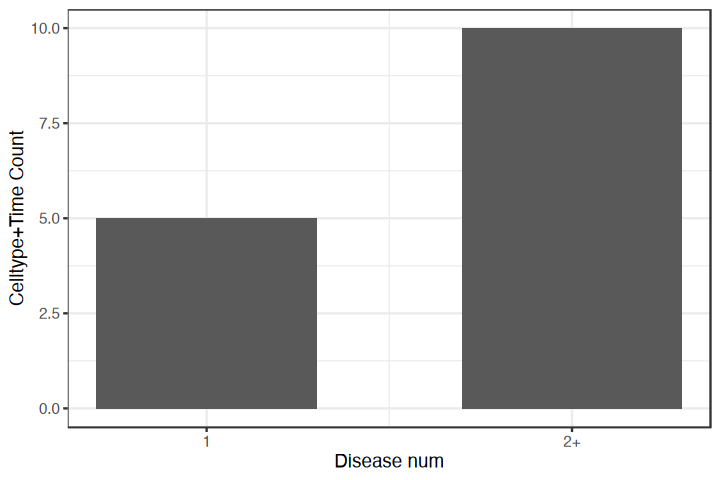

In [241]:
options(repr.plot.width=6, repr.plot.height=4)
a=tmp_lung_res0 %>%
    group_by(Description) %>%
    dplyr::summarise(num=length(unique(Celltype))) %>% 
    mutate(num = ifelse(num>2, 2, num)) %>%
    ggplot(aes(x=num))+
    geom_bar(stat='count', width=0.6)+
    scale_x_continuous(breaks = c(1,2), labels = c(1,'2+'))+
    labs(x='Disease num', y='Celltype+Time Count')+
    theme_bw()
a
ggsave(glue('{output_dir}/Epi_function(differentCsameD).pdf'), a,  
       width=40, height = 50, units='mm', dpi=600, bg='transparent')

In [243]:
tmp_lung_res0 %>%
    group_by(Description) %>%
    dplyr::summarise(num=length(unique(Celltype)))
# affect single disease
single_dis2 = tmp_lung_res0 %>%
    group_by(Description) %>%
    dplyr::summarise(num=length(unique(Celltype))) #%>% 
    #filter(num>1)
single_dis2

Description                                                  num
1  Abnormal lung lobation                                        3 
2  Acute lung injury/Acute respiratory distress syndrome (ARDS)  1 
3  Adenocarcinoma of lung, stage IV                              1 
4  Adenosquamous cell lung cancer                                1 
5  Bulla of lung                                                 2 
6  Chronic lung disease                                          2 
7  Congenital hypoplasia of lung                                12 
8  Giant cell carcinoma of lung                                  1 
9  Large cell carcinoma of lung                                  3 
10 Non-small cell lung cancer stage I                            2 
11 Non-squamous non-small cell lung cancer                       4 
12 Progression of non-small cell lung cancer                     9 
13 Sarcomatoid carcinoma of the lung                             1 
14 Squamous non-small cell lung cancer                           5 
15 stage, non-small cell lung cancer                             6

Description                                                  num
1  Abnormal lung lobation                                        3 
2  Acute lung injury/Acute respiratory distress syndrome (ARDS)  1 
3  Adenocarcinoma of lung, stage IV                              1 
4  Adenosquamous cell lung cancer                                1 
5  Bulla of lung                                                 2 
6  Chronic lung disease                                          2 
7  Congenital hypoplasia of lung                                12 
8  Giant cell carcinoma of lung                                  1 
9  Large cell carcinoma of lung                                  3 
10 Non-small cell lung cancer stage I                            2 
11 Non-squamous non-small cell lung cancer                       4 
12 Progression of non-small cell lung cancer                     9 
13 Sarcomatoid carcinoma of the lung                             1 
14 Squamous non-small cell lung cancer                           5 
15 stage, non-small cell lung cancer                             6

In [244]:
tmp_lung_res0[tmp_lung_res0$Description=='Adenocarcinoma of lung, stage I',]

ID Description GeneRatio BgRatio RichFactor FoldEnrichment zScore pvalue
     p.adjust qvalue geneID Count cluster Celltype Time new_name

In [245]:
pdf(glue('{output_dir}/differentCsameDrelationship network.pdf'), width=12, height=12)
options(repr.plot.width=12, repr.plot.height=10)
par(mfrow=c(3,3))
for(tmp_Description in unique(single_dis2$Description)){
    # tmp_celltype = as.character(mult_dis[i, 'Celltype'])
    # tmp_time = unlist(single_dis2[single_dis2$Celltype==tmp_celltype, 'Description'])
    
    tmp_lung_res = tmp_lung_res0 %>% filter(Description%in%tmp_Description) 
    tmp_lung_res$Celltype = paste0(tmp_lung_res$Celltype, ':', 1:nrow(tmp_lung_res))
    tmp_lung_res$Time = paste0(tmp_lung_res$Time, ':', 1:nrow(tmp_lung_res))
    
    #other_time = setdiff(time_levels,unique(tmp_lung_res$Time))
    #tmp_net = data.frame('Celltype'=tmp_celltype, 'Time'=other_time)

    net_work_data = as.matrix(tmp_lung_res[,c('Celltype', 'Time')])
    net_work_data = rbind(net_work_data, as.matrix(tmp_lung_res[,c('Time', 'Description')]))
    net_work_data = as.data.frame(net_work_data)
    #net_work_data = rbind(net_work_data, tmp_net)
    net_work_data = net_work_data %>% unique()

    g <- graph_from_data_frame(net_work_data , directed = T)


    nodes_color = sapply(names(V(g)), function(x){
        
        if(x %in% net_work_data$Time){
            x = strsplit(x, ':')[[1]][1]
            return(time_color2[x])
        }else if(x %in% net_work_data$Celltype){
            x = strsplit(x, ':')[[1]][1]
            return(tmp_curr_celltype_color2[x])
        }else{
            return('gray')
        }
    })
    nodes_size = sapply(names(V(g)), function(x){
        x = strsplit(x, ':')[[1]][1]
        if(x %in% tmp_lung_res$Time){
            return(12)
        }else if(x %in% tmp_lung_res$Celltype){
            return(18)
        }else{
            return(6)
        }
    })

    set.seed(1234)
    #g_order = c(tmp_celltype, time_levels, unique(tmp_lung_res$Description))
    #    order_idx = match(g_order, V(g)$name)

    ly = layout_as_tree(g)#[order_idx,]
    ly_roate = cbind(-ly[,2], ly[,1])
    plot(g, edge.arrow.size = 0.3, vertex.color = unname(nodes_color), vertex.label.color = "black",
        vertex.size=nodes_size,
         #vertex.label.dist=2, 
         #vertex.label.degree=0,
         layout=ly_roate)
}
dev.off()

agg_record_801979252 
                   2

In [451]:
celltye_time_disease_genes_3 = list()

for(k in 1:nrow(single_dis2)){
    tmp_Description = single_dis2$Description[k]
    tmp_lung_res = tmp_lung_res0 %>% filter(Description%in%tmp_Description) 
    
    tmp_same_gene = NULL
    tmp_unique_gene = list()

    for(j in 1:nrow(tmp_lung_res)){
        tc = tmp_lung_res$Celltype[j]
        tt = tmp_lung_res$Time[j]
        
        i = tmp_lung_res[j, 'geneID']
        tmp_gene = strsplit(i, '/')[[1]]
        if(is.null(tmp_same_gene)){
            tmp_same_gene = tmp_gene
        }else{
            tmp_same_gene = intersect(tmp_same_gene, tmp_gene)
        }
        tmp_unique_gene[[paste0(tc,':',tt)]] = tmp_gene

    }
    tmp_unique_gene_name = list()
    for(i in names(tmp_unique_gene)){
        tmp_gene = setdiff(tmp_unique_gene[[i]], tmp_same_gene)
        tmpgene_id = bitr(tmp_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
        tmp_unique_gene_name[[i]] = tmpgene_id$SYMBOL
    }
    #tmp_unique_gene_name
    tmpgene_id = bitr(tmp_same_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
    #tmpgene_id$SYMBOL
    celltye_time_disease_genes_3[[tmp_Description]] = list('unique'=tmp_unique_gene_name,
                                                             'same'=tmpgene_id$SYMBOL)
}


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' ret

In [452]:
celltye_time_disease_genes_3

$`Abnormal lung lobation`
$`Abnormal lung lobation`$unique
$`Abnormal lung lobation`$unique$`AT1_Tldc2:P11`
[1] "FOXF1" "RSPO2" "FREM2" "CEP57"

$`Abnormal lung lobation`$unique$`AT1_Mfrp:P1`
[1] "FRAS1" "GP1BB" "GPC3"  "RREB1" "ARVCF"

$`Abnormal lung lobation`$unique$`AT2_Sgta:P13`
[1] "RSPO2"  "FRAS1"  "FREM2"  "ARVCF"  "RREB1"  "JMJD1C" "AKT1"  


$`Abnormal lung lobation`$same
[1] "GLI3"


$`Bulla of lung`
$`Bulla of lung`$unique
$`Bulla of lung`$unique$`AT2_Gfra1:P3`
[1] "SLC9A6" "CTNNB1"

$`Bulla of lung`$unique$`Airway_Club_Scgb1a1:P5`
[1] "HSPG2" "GYPC"  "EPHX1"


$`Bulla of lung`$same
[1] "SMAD2" "TIMP2"


$`Chronic lung disease`
$`Chronic lung disease`$unique
$`Chronic lung disease`$unique$`Airway_Cilitated_Lypd2:P13`
 [1] "APPBP2"   "RIPK1"    "CSPP1"    "KRT18"    "BCL2"     "CCL5"    
 [7] "SERPINA1" "DNAH11"   "GSTM1"    "LAT"      "FBLN5"    "GRP"     
[13] "MRC1"     "ELN"      "PEPD"     "IGF1R"    "BLM"      "ANGPT2"  

$`Chronic lung disease`$unique$`Airway_Club_Sftpb:P9`
[1] "VEGFA"  "FSTL1"  "PDGFA"  "CLTC"   "IL13"   "NKX2-1"


$`Chronic lung disease`$same
[1] "BRD4"


$`Congenital hypoplasia of lung`
$`Congenital hypoplasia of lung`$unique
$`Congenital hypoplasia of lung`$unique$`AT1:P12`
 [1] "GSTM2"  "AGT"    "CCND1"  "EGF"    "TP63"   "CHRNA1" "GATA6"  "PRKCA" 
 [9] "PSAT1"  "DHCR7"  "TPM3"   "NFIB"   "MAPK6"  "PIGN"   "PIK3CG" "CRB2"  
[17] "NEB"    "FREM2"  "NDC1"   "TBX2"   "GREB1L" "FRAS1"  "GLI3"   "NKX2-1"
[25] "ASCC1"  "IFT81"  "EGFR"   "CC2D2A" "NOTCH2"

$`Congenital hypoplasia of lung`$unique$`AT1:P4`
 [1] "PIK3CB"  "TGFB1"   "EFNB1"   "VEGFA"   "DHCR7"   "PIK3CD"  "NKX2-1" 
 [8] "GLI3"    "SLC26A2" "FLNB"    "PHGDH"   "AGT"     "FAM20C"  "CEP120" 
[15] "ACE"     "RARB"   

$`Congenital hypoplasia of lung`$unique$`AT1_Nek10:P0`
 [1] "KAT6B"  "CRB2"   "NDST1"  "HSPG2"  "SFTPB"  "VEGFA"  "NOTCH2" "SETBP1"
 [9] "FOXA2"  "EGFR"   "COL2A1" "KRAS"   "RET"    "PRKCA"  "IFT80"  "FRAS1" 
[17] "LMNA"   "LIFR"   "NFIA"   "CCND1"  "ITGA3"  "RARB"  

$`Congenital hypoplasia of lung`$unique$`AT1_Nek10:P10`
 [1] "ERBB4"   "WNT4"    "FOXA2"   "EGF"     "GLI3"    "FLNA"    "NFIB"   
 [8] "SPECC1L" "VEGFA"   "MCTP2"   "PIK3CB" 

$`Congenital hypoplasia of lung`$unique$`AT1_Agt:P5`
[1] "LIFR"    "SLC26A2" "VANGL1"  "CCND1"   "NR3C1"   "PRKCA"   "IFT81"  
[8] "KAT6B"   "LTBP4"  

$`Congenital hypoplasia of lung`$unique$`AT1_Agt:P7`
 [1] "DYNC2H1" "WDR35"   "EFNB1"   "MKS1"    "MAPK12"  "EGFR"    "NR3C1"  
 [8] "RET"     "STAT3"   "RARB"    "PHGDH"   "KAT6B"   "NFIA"    "PIGN"   
[15] "FRAS1"   "LTBP4"   "ROR2"   

$`Congenital hypoplasia of lung`$unique$`AT1_Agt:P12`
 [1] "FLNB"     "MUSK"     "BICC1"    "GATA6"    "TMEM151B" "GREB1L"  
 [7] "PRKCA"    "MYL2"     "KAT6B"    "NIPBL"    "NR3C1"    "CEP120"  
[13] "NEK1"     "GRIP1"    "TPM3"     "NFIB"     "WNT4"     "TBX5"    
[19] "RBM10"    "CDH10"    "NFIA"     "BMPER"    "BNC2"     "DISP1"   
[25] "WDR35"    "FOXA2"   

$`Congenital hypoplasia of lung`$unique$`AT1_Tldc2:P0`
 [1] "NDST1"    "SFTPB"    "NOTCH2"   "SETBP1"   "COL2A1"   "RET"     
 [7] "FRAS1"    "FOXA2"    "CCND1"    "KAT6B"    "LMNA"     "VEGFA"   
[13] "HSPG2"    "TPM2"     "TGFA"     "NFIB"     "LIFR"     "GATA4"   
[19] "SLC25A24" "DISP1"    "NFIA"     "GSTM1"    "EFNB1"   

$`Congenital hypoplasia of lung`$unique$`AT1_Tldc2:P10`
 [1] "ASCC1"   "PRKCA"   "VEGFA"   "DYNC2H1" "MCTP2"   "WDR35"   "FGF20"  
 [8] "CCND1"   "INVS"    "SFTPB"   "ROR2"    "FLNA"    "PIGN"    "GRIP1"  
[15] "EFNB1"  

$`Congenital hypoplasia of lung`$unique$`AT1_Mfrp:P10`
 [1] "GLIPR1"   "CD44"     "PIK3CB"   "BMPER"    "PIGN"     "BICC1"   
 [7] "ROR2"     "FGF10"    "LIFR"     "GREB1L"   "SETBP1"   "CRB2"    
[13] "FOXA2"    "GHSR"     "KAT6B"    "GATA6"    "INTU"     "ZMPSTE24"
[19] "MAPK6"    "ZFPM2"    "ACTA1"    "EGFR"     "DISP1"    "STAT3"   
[25] "LMNA"     "PRKCA"    "PIK3CA"   "FSTL1"   

$`Congenital hypoplasia of lung`$unique$`AT2:P12`
 [1] "TP63"    "GATA6"   "PRKCA"   "GREB1L"  "RET"     "NFIB"    "SL

## sametime、differentcell、samedisease

`summarise()` has grouped output by 'Time'. You can override using the
`.groups` argument.


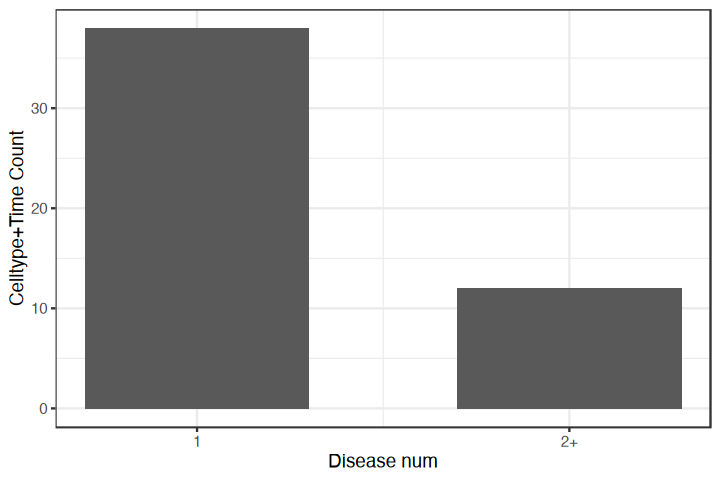

In [234]:
options(repr.plot.width=6, repr.plot.height=4)
a=tmp_lung_res0 %>%
    group_by(Time, Description) %>%
    dplyr::summarise(num=n()) %>%
    mutate(num = ifelse(num>2, 2, num)) %>%
    ggplot(aes(x=num))+
    geom_bar(stat='count', width=0.6)+
    scale_x_continuous(breaks = c(1,2), labels = c(1,'2+'))+
    labs(x='Disease num', y='Celltype+Time Count')+
    theme_bw()
a
ggsave(glue('{output_dir}/Epi_function(sameTdifferentCsameD).pdf'), a,  
       width=40, height = 50, units='mm', dpi=600, bg='transparent')

In [238]:
# affect single disease
single_dis3 = tmp_lung_res0 %>%
    group_by(Time, Description) %>%
    dplyr::summarise(num=n()) #%>% 
    #filter(num>1)

`summarise()` has grouped output by 'Time'. You can override using the
`.groups` argument.


In [239]:
length(unique(single_dis3$Time))

[1] 15

In [240]:
pdf(glue('{output_dir}/sameTdifferentCsameDrelationship network.pdf'), width=12, height=12)
options(repr.plot.width=12, repr.plot.height=16)
par(mfrow=c(4,4))
for(tmp_celltype in unique(single_dis3$Time)){
    # tmp_celltype = as.character(mult_dis[i, 'Celltype'])
    tmp_time = unlist(single_dis3[single_dis3$Time==tmp_celltype, 'Description'])
    
    tmp_lung_res = tmp_lung_res0 %>% filter(Time==tmp_celltype, Description%in%tmp_time) 
    #other_time = setdiff(time_levels,unique(tmp_lung_res$Time))
    #tmp_net = data.frame('Celltype'=tmp_celltype, 'Time'=other_time)

    net_work_data = as.matrix(tmp_lung_res[,c('Time','Celltype')])
    net_work_data = rbind(net_work_data, as.matrix(tmp_lung_res[,c('Celltype', 'Description')]))
    net_work_data = as.data.frame(net_work_data)
    #net_work_data = rbind(net_work_data, tmp_net)
    net_work_data = net_work_data %>% unique()

    g <- graph_from_data_frame(net_work_data , directed = T)


    nodes_color =  sapply(names(V(g)), function(x){
     
        if(x %in% names(time_color2)){
            return(time_color2[x])
        }else if(x %in% names(tmp_curr_celltype_color2)){
            return(tmp_curr_celltype_color2[x])
        }else{
            return('gray')
        }
    })
    nodes_size = sapply(names(V(g)), function(x){
        if(x %in% tmp_lung_res$Time){
            return(12)
        }else if(x %in% tmp_lung_res$Celltype){
            return(18)
        }else{
            return(6)
        }
    })

    set.seed(1234)
    #g_order = c(tmp_celltype, time_levels, unique(tmp_lung_res$Description))
    #    order_idx = match(g_order, V(g)$name)

    ly = layout_as_tree(g)#[order_idx,]
    ly_roate = cbind(-ly[,2], ly[,1])
    plot(g, edge.arrow.size = 0.3, vertex.color = nodes_color, vertex.label.color = "black",
        vertex.size=nodes_size,
         vertex.label.dist=2, 
         vertex.label.degree=0,
         layout=ly_roate)
}
dev.off()

agg_record_831490948 
                   2

In [457]:
single_dis3

Time Description                               num
1  P0   Congenital hypoplasia of lung             2  
2  P10  Congenital hypoplasia of lung             3  
3  P11  Progression of non-small cell lung cancer 2  
4  P11  stage, non-small cell lung cancer         2  
5  P12  Congenital hypoplasia of lung             6  
6  P12  Non-squamous non-small cell lung cancer   2  
7  P14  Congenital hypoplasia of lung             2  
8  P14  Progression of non-small cell lung cancer 3  
9  P14  Squamous non-small cell lung cancer       2  
10 P5   Congenital hypoplasia of lung             2  
11 P7   Congenital hypoplasia of lung             3  
12 P8   Congenital hypoplasia of lung             3

In [458]:
celltye_time_disease_genes_4 = list()

for(k in 1:nrow(single_dis3)){
    tmp_Description = single_dis3$Description[k]
    tt = single_dis3$Time[k]
    tmp_lung_res = tmp_lung_res0 %>% filter(Description%in%tmp_Description) %>% filter(Time%in%tt) 
    
    tmp_same_gene = NULL
    tmp_unique_gene = list()

    for(j in 1:nrow(tmp_lung_res)){
        tc = tmp_lung_res$Celltype[j]
        i = tmp_lung_res[j, 'geneID']
        tmp_gene = strsplit(i, '/')[[1]]
        if(is.null(tmp_same_gene)){
            tmp_same_gene = tmp_gene
        }else{
            tmp_same_gene = intersect(tmp_same_gene, tmp_gene)
        }
        tmp_unique_gene[[paste0(tmp_Description,':',tc)]] = tmp_gene

    }
    tmp_unique_gene_name = list()
    for(i in names(tmp_unique_gene)){
        tmp_gene = setdiff(tmp_unique_gene[[i]], tmp_same_gene)
        tmpgene_id = bitr(tmp_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
        tmp_unique_gene_name[[i]] = tmpgene_id$SYMBOL
    }
    #tmp_unique_gene_name
    tmpgene_id = bitr(tmp_same_gene,toType = 'SYMBOL', fromType = c('ENTREZID'), OrgDb = 'org.Hs.eg.db')
    #tmpgene_id$SYMBOL
    celltye_time_disease_genes_4[[tt]] = list('unique'=tmp_unique_gene_name,
                                              'same'=tmpgene_id$SYMBOL)
}


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' ret

In [459]:
celltye_time_disease_genes_4

$P0
$P0$unique
$P0$unique$`Congenital hypoplasia of lung:AT1_Nek10`
[1] "CRB2"  "EGFR"  "KRAS"  "PRKCA" "IFT80" "ITGA3" "RARB" 

$P0$unique$`Congenital hypoplasia of lung:AT1_Tldc2`
[1] "TPM2"     "TGFA"     "NFIB"     "GATA4"    "SLC25A24" "DISP1"    "GSTM1"   
[8] "EFNB1"   


$P0$same
 [1] "KAT6B"  "NDST1"  "HSPG2"  "SFTPB"  "VEGFA"  "NOTCH2" "SETBP1" "FOXA2" 
 [9] "COL2A1" "RET"    "FRAS1"  "LMNA"   "LIFR"   "NFIA"   "CCND1" 


$P10
$P10$unique
$P10$unique$`Congenital hypoplasia of lung:AT1_Nek10`
 [1] "ERBB4"   "WNT4"    "FOXA2"   "EGF"     "GLI3"    "FLNA"    "NFIB"   
 [8] "SPECC1L" "VEGFA"   "MCTP2"   "PIK3CB" 

$P10$unique$`Congenital hypoplasia of lung:AT1_Tldc2`
 [1] "ASCC1"   "PRKCA"   "VEGFA"   "DYNC2H1" "MCTP2"   "WDR35"   "FGF20"  
 [8] "CCND1"   "INVS"    "SFTPB"   "ROR2"    "FLNA"    "PIGN"    "GRIP1"  
[15] "EFNB1"  

$P10$unique$`Congenital hypoplasia of lung:AT1_Mfrp`
 [1] "GLIPR1"   "CD44"     "PIK3CB"   "BMPER"    "PIGN"     "BICC1"   
 [7] "ROR2"     "FGF10"    "LIFR"     "GREB1L"   "SETBP1"   "CRB2"    
[13] "FOXA2"    "GHSR"     "KAT6B"    "GATA6"    "INTU"     "ZMPSTE24"
[19] "MAPK6"    "ZFPM2"    "ACTA1"    "EGFR"     "DISP1"    "STAT3"   
[25] "LMNA"     "PRKCA"    "PIK3CA"   "FSTL1"   


$P10$same
character(0)


$P11
$P11$unique
$P11$unique$`stage, non-small cell lung cancer:AT1_Tldc2`
[1] "ROS1"  "MYC"   "S100B" "KRAS"  "CYTIP" "CUX1"  "BTG2"  "KRT19"

$P11$unique$`stage, non-small cell lung cancer:AT2`
[1] "PCNA"  "CSF2"  "EPHB6" "RET"  


$P11$same
[1] "DAB2IP"


$P12
$P12$unique
$P12$unique$`Non-squamous non-small cell lung cancer:Airway_Acp7`
[1] "CD274" "RET"   "ERCC1" "VIM"   "ALK"  

$P12$unique$`Non-squamous non-small cell lung cancer:Airway_Club_Sftpb`
[1] "NKX2-1" "EGF"    "VEGFA" 


$P12$same
[1] "PIK3CD" "MET"    "PIK3CB"


$P14
$P14$unique
$P14$unique$`Squamous non-small cell lung cancer:AT2_Gfra1`
[1] "PIK3C2B" "IGF1"    "PIK3CG" 

$P14$unique$`Squamous non-small cell lung cancer:Airway_Club_Sftpb`
[1] "BRAF"     "EGFR"     "TNFRSF18"


$P14$same
[1] "NKX2-1" "PAK1"   "PIK3CB" "GDNF"   "SOX2"  


$P5
$P5$unique
$P5$unique$`Congenital hypoplasia of lung:AT1_Agt`
[1] "LIFR"    "SLC26A2" "VANGL1"  "CCND1"   "IFT81"   "KAT6B"   "LTBP4"  

$P5$unique$`Congenital hypoplasia of lung:Airway_Spock3`
 [1] "TP63"     "SPECC1L"  "STAT3"    "FLNB"     "PIEZO2"   "NFIB"    
 [7] "PKHD1"    "GRIP1"    "TBX4"     "PIK3CG"   "GLI3"     "ROR2"    
[13] "GATA4"    "ZFPM2"    "GREB1L"   "CEP120"   "SETBP1"   "ITGA8"   
[19] "GSTM1"    "SLC25A24" "MUSK"     "BNC2"     "FAM20C"   "LEP"     
[25] "MCTP2"   


$P5$same
[1] "NR3C1" "PRKCA"


$P7
$P7$unique
$P7$unique$`Congenital hypoplasia of lung:AT1_Agt`
 [1] "DYNC2H1" "WDR35"   "MKS1"    "MAPK12"  "EGFR"    "NR3C1"   "RET"    
 [8] "STAT3"   "RARB"    "PHGDH"   "KAT6B"   "PIGN"    "FRAS1"   "LTBP4"  
[15] "ROR2"   

$P7$unique$`Congenital hypoplasia of lung:AT2_Gfra1`
[1] "PIK3CB" "FLNB"   "FGF20"  "SFTPB"  "LIFR"   "MCTP2"  "CCND1"  "PRKCA" 

$P7$unique$`Congenital hypoplasia of lung:Airway_Club_Scgb1a1`
 [1] "REN"    "FREM2"  "NOTCH2" "PRKCA"  "PKD1"   "NR2F2"  "FOXA2"  "GRIP1" 
 [9] "ZFPM2"  "CRB2"   "TPM3"   "BNC2"   "NFIB"   "MCTP2"  "CD44"   "SFTPC" 
[17] "PKHD1"  "MYRF"   "SETBP1" "TPM2"  


$P7$same
[1] "EFNB1" "NFIA" 


$P8
$P8$unique
$P8$unique$`Congenital hypoplasia of lung:Airway_Cilitated_Lypd2`
 [1] "SFTPC"  "NKX2-1" "MCTP2"  "GLI3"   "ROR2"   "PIK3CB" "FANCB"  "PIGN"  
 [9] "SFTPB"  "NDC1"   "LIFR"   "NEB"    "NEK1"   "FOXA2"  "BICC1"  "CEP120"
[17] "GRIP1"  "FSTL1"  "NIPBL"  "PRKCA"  "FAM20C"

$P8$unique$`Congenital hypoplasia of lung:Airway_Acp7`
 [1] "BICC1"  "GATA6"  "RET"    "HMMR"   "LTBP4"  "FLNB"   "NEK8"   "COQ7"  
 [9] "HSPG2"  "ITGA6"  "FREM2"  "FAM20C" "FSTL1"  "EFNB1"  "LBR"   

$P8$unique$`Congenital hypoplasia of lung:Airway_Spock3`
 [1] "EFNB1"    "SLC26A2"  "PKHD1"    "DISP1"    "EGFR"     "NUP88"   
 [7] "TBX4"     "MKS1"     "PRKCA"    "KIAA0586" "ROR2"     "CDH10"   
[13] "ZFPM2"    "GATA6"    "CEP120"   "PIEZO2"   "PSAT

## EGFR

In [258]:
myfragments=list()
for(x in Fragments(srt)){
    if(length(x@cells)>0){
        xname = x@path
        if(xname %in% names(myfragments)){
            myfragments[[xname]]@cells = c(myfragments[[xname]]@cells, x@cells)
        }else{
            myfragments[[xname]] = x
        }
    }
}
myfragments = unname(myfragments)

Fragments(srt) = NULL

Fragments(srt) = myfragments

In [259]:
srt_markers_filter2 = srt_markers %>% 
    filter( avg_log2FC>0) %>% #p_val_adj<0.05,
    group_by(cluster) %>%
    dplyr::top_n(2000, avg_log2FC)

cluster_top_genes2 = list()
for(i in unique(srt_markers_filter2$cluster)){
    tmp_genes = srt_markers_filter2[srt_markers_filter2$cluster==i,'gene', drop=T]
    tmp_genes = srt_close_genes[srt_close_genes$query_region%in%tmp_genes,]
    tmp_genes = unique(na.omit(tmp_genes$hg38gene))
    tmp_genes = tmp_genes[tmp_genes!='']
    cluster_top_genes2[[i]] = unique(na.omit(tmp_genes))
}

In [342]:
celltye_time_disease_genes_1[['AT1_Mfrp.103:P1']]

$unique
$unique$`Abnormal lung lobation`
character(0)


$same
[1] "FRAS1" "GP1BB" "GLI3"  "GPC3"  "RREB1" "ARVCF"

In [257]:
celltye_time_disease_genes_1[['AT1_Nek10.112:P0']]

$unique
$unique$`Adenosquamous cell lung cancer`
[1] "ERBB2" "KRAS"  "RET"   "KIF5B"

$unique$`Non-small cell lung cancer stage I`
 [1] "SLC1A5" "S100A6" "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CDH13" 
 [9] "FHIT"   "FOXA2"  "HIF1A"  "EPHA2"  "DCLK1"  "EFNA1"  "RARB"  

$unique$`stage, non-small cell lung cancer`
 [1] "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CUX1"   "HIF1A"  "KRAS"  
 [9] "RET"    "NOS3"   "BTG2"   "MAPK3"  "DAB2IP" "CCND1" 

$unique$`Progression of non-small cell lung cancer`
 [1] "MDM2"   "FAM83F" "LATS2"  "CDK14"  "HIF1A"  "TMPO"   "EPHA2"  "PIK3R1"
 [9] "SMAD7"  "IL6R"   "FOXN1"  "HOPX"   "SMAD3"  "TOPORS"

$unique$`Congenital hypoplasia of lung`
 [1] "KAT6B"  "CRB2"   "NDST1"  "HSPG2"  "SFTPB"  "VEGFA"  "NOTCH2" "SETBP1"
 [9] "FOXA2"  "COL2A1" "KRAS"   "RET"    "PRKCA"  "IFT80"  "FRAS1"  "LMNA"  
[17] "LIFR"   "NFIA"   "CCND1"  "ITGA3"  "RARB"  


$same
[1] "EGFR"

In [503]:
#options(jupyter.plot_mimetypes = c("image/png", "image/jpeg", "image/svg+xml"))
xx = celltye_time_disease_genes_1[['AT1_Nek10.112:P0']]$unique
xx$`Adenosquamous cell lung cancer` = c(xx$`Adenosquamous cell lung cancer`, 'EGFR')
xx$`Non-small cell lung cancer stage I` = c(xx$`Non-small cell lung cancer stage I`, 'EGFR')
xx$`stage, non-small cell lung cancer` = c(xx$`stage, non-small cell lung cancer`, 'EGFR')
xx$`Progression of non-small cell lung cancer` = c(xx$`Progression of non-small cell lung cancer`, 'EGFR')
xx$`Congenital hypoplasia of lung` = c(xx$`Congenital hypoplasia of lung`, 'EGFR')

lt = list_to_matrix(xx)
m1 = make_comb_mat(lt)
pdf(glue('{output_dir}/AT1_nek10_geneset.pdf'), width = 12,height = 4)
draw(UpSet(m1))
dev.off()


agg_record_1866126540 
                    2

In [516]:
aa = intersect(xx$`Congenital hypoplasia of lung`, xx$`Non-small cell lung cancer stage I`)
intersect(aa, xx$`stage, non-small cell lung cancer`)

aa = intersect(xx$`Congenital hypoplasia of lung`, xx$`stage, non-small cell lung cancer`)
intersect(aa, xx$`Adenosquamous cell lung cancer`)

aa = intersect(xx$`Non-small cell lung cancer stage I`, xx$`stage, non-small cell lung cancer`)
intersect(aa, xx$`Progression of non-small cell lung cancer`)

aa = intersect(xx$`Non-small cell lung cancer stage I`, xx$`stage, non-small cell lung cancer`)
intersect(aa, xx$`Adenosquamous cell lung cancer`)

intersect(xx$`Congenital hypoplasia of lung`, xx$`Non-small cell lung cancer stage I`)

intersect(xx$`Congenital hypoplasia of lung`, xx$`stage, non-small cell lung cancer`)

intersect(xx$`Non-small cell lung cancer stage I`, xx$`stage, non-small cell lung cancer`)

intersect(xx$`Non-small cell lung cancer stage I`, xx$`Progression of non-small cell lung cancer`)

[1] "VEGFA" "EGFR"

[1] "KRAS" "RET"  "EGFR"

[1] "MDM2"  "HIF1A" "EGFR"

[1] "ERBB2" "EGFR"

[1] "VEGFA" "FOXA2" "RARB"  "EGFR"

[1] "VEGFA" "KRAS"  "RET"   "CCND1" "EGFR"

[1] "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "HIF1A"  "EGFR"

[1] "MDM2"  "HIF1A" "EPHA2" "EGFR"

In [673]:
xx

$`Adenosquamous cell lung cancer`
[1] "ERBB2" "KRAS"  "RET"   "KIF5B" "EGFR" 

$`Non-small cell lung cancer stage I`
 [1] "SLC1A5" "S100A6" "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CDH13" 
 [9] "FHIT"   "FOXA2"  "HIF1A"  "EPHA2"  "DCLK1"  "EFNA1"  "RARB"   "EGFR"  

$`stage, non-small cell lung cancer`
 [1] "MDM2"   "FGFR1"  "S100A2" "ERBB2"  "VEGFA"  "CUX1"   "HIF1A"  "KRAS"  
 [9] "RET"    "NOS3"   "BTG2"   "MAPK3"  "DAB2IP" "CCND1"  "EGFR"  

$`Progression of non-small cell lung cancer`
 [1] "MDM2"   "FAM83F" "LATS2"  "CDK14"  "HIF1A"  "TMPO"   "EPHA2"  "PIK3R1"
 [9] "SMAD7"  "IL6R"   "FOXN1"  "HOPX"   "SMAD3"  "TOPORS" "EGFR"  

$`Congenital hypoplasia of lung`
 [1] "KAT6B"  "CRB2"   "NDST1"  "HSPG2"  "SFTPB"  "VEGFA"  "NOTCH2" "SETBP1"
 [9] "FOXA2"  "COL2A1" "KRAS"   "RET"    "PRKCA"  "IFT80"  "FRAS1"  "LMNA"  
[17] "LIFR"   "NFIA"   "CCND1"  "ITGA3"  "RARB"   "EGFR"

In [ ]:

tmp_gene=c('Egfr')
cur_cre = c('chr11-16769901-16770402','chr18-60714271-60714772')
#cur_cre = tmp_gene_cre2 %>% filter(cluster%in%tmp_cluster) %>% pull(gene)

In [738]:
tmp_srt = subset(srt, Celltype_round4=='AT1_Nek10')

In [739]:
tmp_srt$Time = factor(tmp_srt$Time, time_levels)

In [756]:
tmp_srt@assays$CRE@meta.features[,'peak_group'] = 'false'
tmp_srt@assays$CRE@meta.features[cur_cre,'peak_group'] = 'true'

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


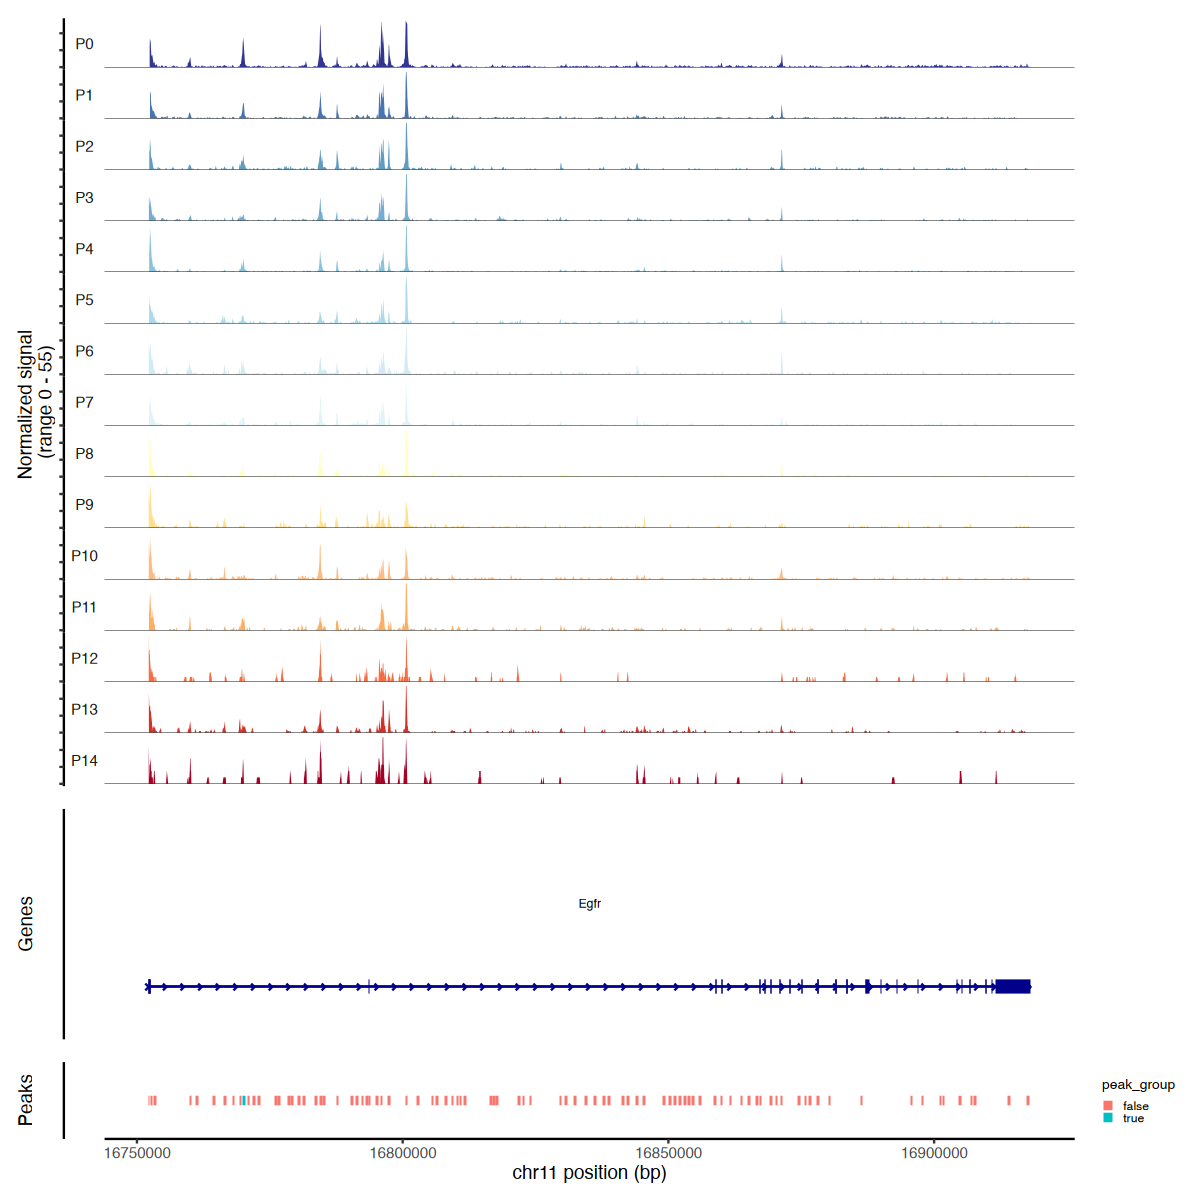

In [769]:
options(repr.plot.width=10, repr.plot.height=10)

a=CoveragePlot(tmp_srt, 
               region = tmp_gene,#c('chr11-16769901-16770402'),#'chr7-144963831-144964332',
               group.by = 'Time',
               ymax='q50', 
               peaks.group.by='peak_group',
               window=200, 
               extend.upstream = 0,
               extend.downstream = 0,
              )&  scale_fill_manual(values = time_color2)
a
ggsave(glue('{output_dir}/AT1_nek10_Egfr_CoveragePlot.pdf'), a,  
       width=100, height = 120, units='mm', dpi=600, bg='transparent')


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


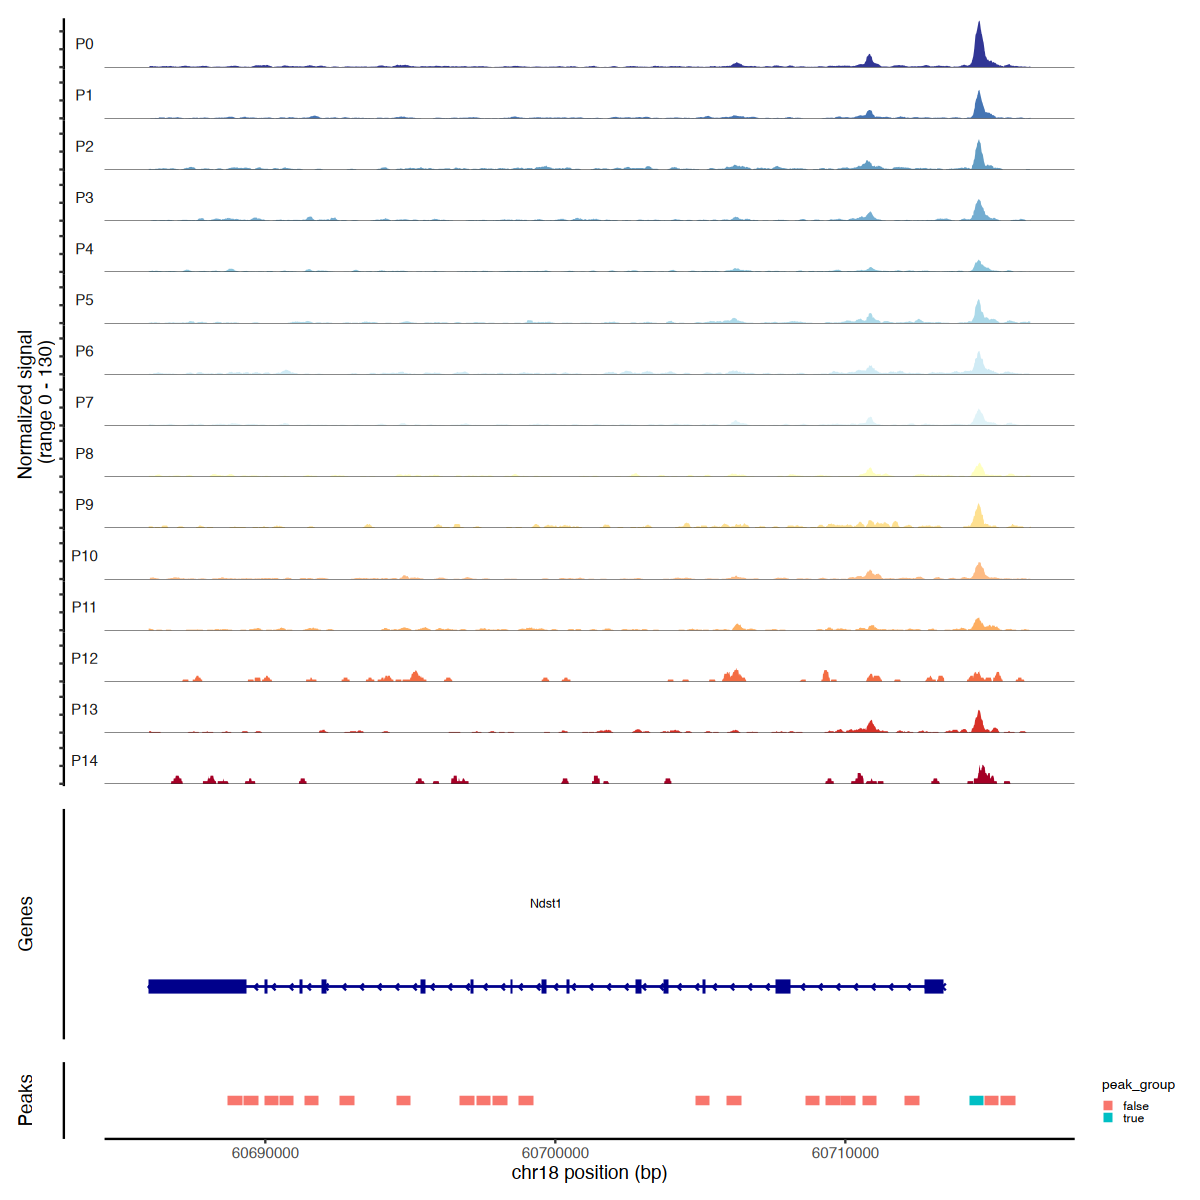

In [768]:
options(repr.plot.width=10, repr.plot.height=10)

a=CoveragePlot(tmp_srt, 
               region = 'Ndst1',#c('chr11-16769901-16770402'),#'chr7-144963831-144964332',
               group.by = 'Time',
               #ymax='q50', 
               peaks.group.by='peak_group',
               window=200, 
               extend.upstream = 0,
               extend.downstream = 3000,
               cols=time_color2
              )&  scale_fill_manual(values = time_color2)
a
ggsave(glue('{output_dir}/AT1_nek10_Ndst1_CoveragePlot.pdf'), a,  
       width=100, height = 120, units='mm', dpi=600, bg='transparent')


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


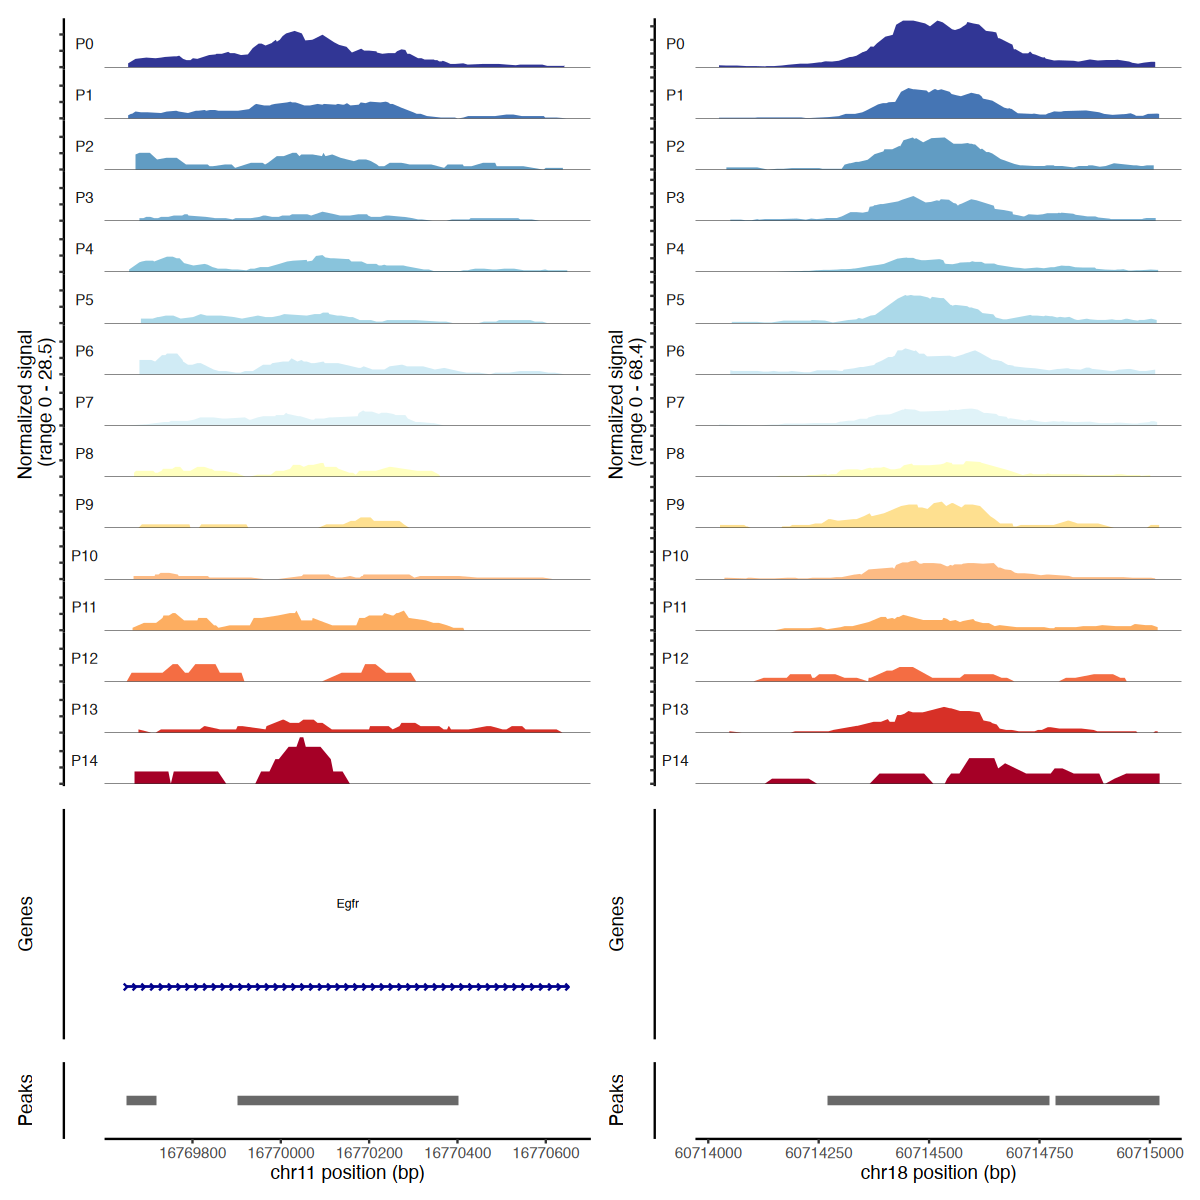

In [771]:
options(repr.plot.width=10, repr.plot.height=10)
a=CoveragePlot(tmp_srt, 
               region = cur_cre,#c('chr11-16769901-16770402'),#'chr7-144963831-144964332',
               group.by = 'Time',
               ymax='q95', 
               window=100, 
               extend.upstream = 250,
               extend.downstream = 250
              )&  scale_fill_manual(values = time_color2)
a
ggsave(glue('{output_dir}/AT1_nek10_Egfr_Ndst1_cre_CoveragePlot.pdf'), a,  
       width=100, height = 120, units='mm', dpi=600, bg='transparent')

In [ ]:
p0_srt = srt

In [23]:
p0_srt$new_name = new_celltype[as.vector(p0_srt$Celltype_round4),'new_name']

In [12]:
umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Endothelium//cell_meta_ann.csv'))
rownames(umap) = umap$X

same_bc = intersect(umap$X,colnames(p0_srt))

head(unlist(umap[same_bc, c('UMAP_1')]))
p0_srt@reductions$umap@cell.embeddings[same_bc, 1] = unlist(umap[same_bc, c('UMAP_1')])
p0_srt@reductions$umap@cell.embeddings[same_bc, 2] = unlist(umap[same_bc, c('UMAP_2')])

[1] -0.40904674 -1.22078240 -2.54068830 12.26224300 -2.74313120  0.02592723

In [24]:
tmp_umap = p0_srt@meta.data
tmp_umap[,c('UMAP_1', 'UMAP_2')] = p0_srt@reductions$umap@cell.embeddings

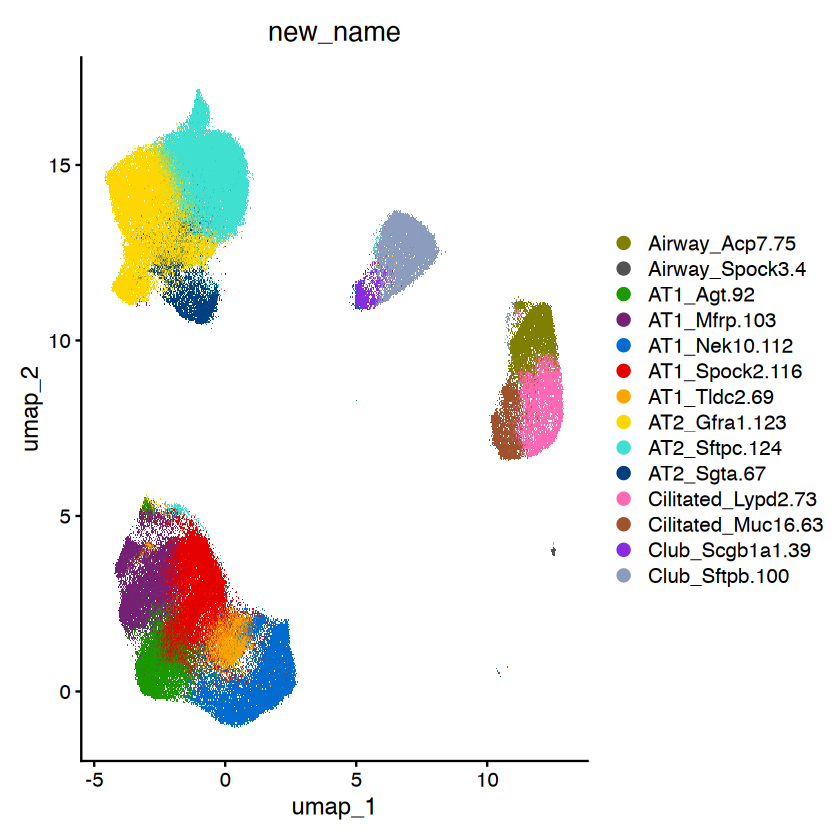

In [32]:
a = DimPlot(p0_srt, group.by = 'new_name', cols = tmp_curr_celltype_color2, raster = T)
a
ggsave(glue('{output_dir}/Epi_umap_legend.pdf'), get_legend(a),
       width=450, height=150, units='mm', dpi=600, bg='transparent')
ggsave(glue('{output_dir}/Epi_umap.pdf'), a+NoLegend(),
       width=160, height=160, units='mm', dpi=600, bg='transparent')

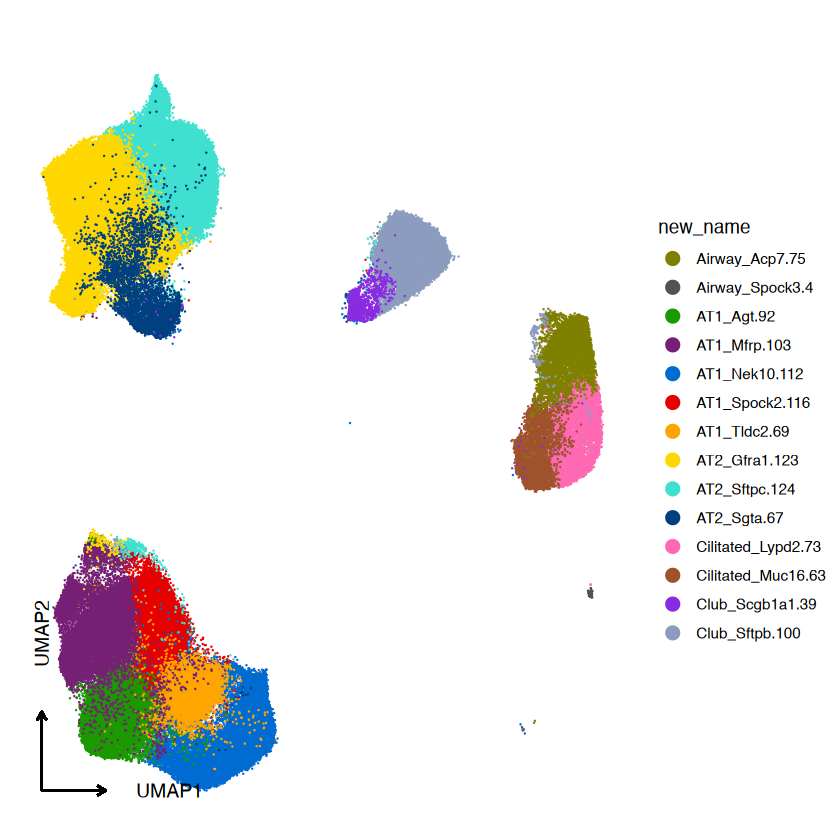

In [29]:
a = myDimPlot(tmp_umap, groupby='new_name', label=FALSE, group_color=tmp_curr_celltype_color2, point_size=0.4)
a
ggsave(glue('{output_dir}/Epi_umap_legend.pdf'), get_legend(a),
       width=450, height=150, units='mm', dpi=600, bg='transparent')
ggsave(glue('{output_dir}/Epi_umap.pdf'), a+NoLegend(),
       width=160, height=160, units='mm', dpi=600, bg='transparent')

In [ ]:
# ggsave(glue('{output_dir}/Epi_umap.pdf'), a,  
#        width=140, height = 100, units='mm', dpi=600, bg='transparent')

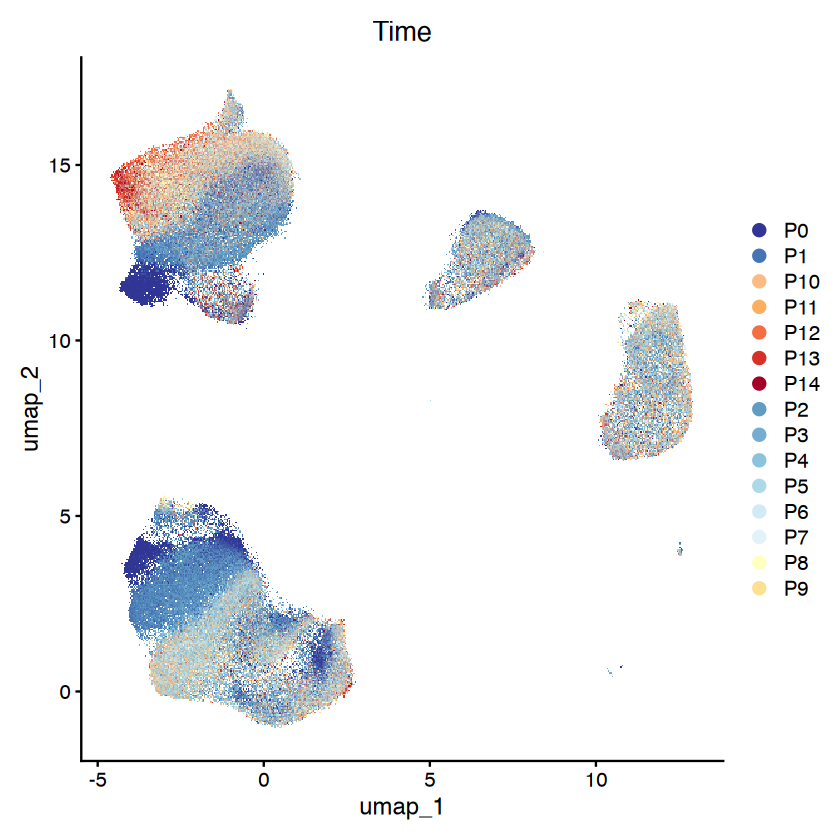

In [33]:
a = DimPlot(p0_srt, group.by = 'Time', cols = time_color2, raster = T)
a
ggsave(glue('{output_dir}/Epi_umap(Time)_legend.pdf'), get_legend(a),
       width=450, height=150, units='mm', dpi=600, bg='transparent')
ggsave(glue('{output_dir}/Epi_umap(Time).pdf'), a+NoLegend(),
       width=160, height=160, units='mm', dpi=600, bg='transparent')

In [207]:
tmp_lung_res0 = read.table(glue('{output_dir}/Lung_enrich.txt'), header=T, sep='\t')

In [208]:
head(tmp_lung_res0)

ID       Description                        GeneRatio BgRatio   RichFactor
1 C0854988 Adenocarcinoma of lung, stage IV   5/584     15/13316  0.3333333 
2 C0265783 Congenital hypoplasia of lung      29/1309   156/13316 0.1858974 
3 C0265783 Congenital hypoplasia of lung      16/697    156/13316 0.1025641 
4 C0279557 Adenosquamous cell lung cancer     5/1085    11/13316  0.4545455 
5 C0278504 Non-small cell lung cancer stage I 16/1085   84/13316  0.1904762 
6 C0280217 stage, non-small cell lung cancer  15/1085   78/13316  0.1923077 
  FoldEnrichment zScore   pvalue      p.adjust   qvalue    
1 7.600457       5.477800 0.000331919 0.13135358 0.12440451
2 1.891070       3.696317 0.000560523 0.07041443 0.06661661
3 1.959460       2.832929 0.007679709 0.21468939 0.19555343
4 5.578550       4.524508 0.001083388 0.05163682 0.04590604
5 2.337678       3.662967 0.001089464 0.05163682 0.04590604
6 2.360156       3.588222 0.001392789 0.05720663 0.05085771
  geneID                                                                                                                                                    
1 3855/6098/1956/9788/7080                                                                                                                                  
2 2946/183/595/1950/8626/1134/2627/5578/29968/1717/7170/4781/5597/23556/5294/286204/4703/341640/55706/6909/80000/80144/2737/7080/51008/28981/1956/57545/4853
3 5291/7040/1947/7422/1717/5293/7080/2737/1836/2317/26227/183/56975/153241/1636/5915                                                                        
4 2064/1956/3845/5979/3799                                                                                                                                  
5 6510/6277/4193/2260/6273/2064/7422/1012/2272/3170/1956/3091/1969/9201/1942/5915                                                                           
6 4193/2260/6273/2064/7422/1523/1956/3091/3845/5979/4846/7832/5595/153090/595                                                                               
  Count cluster      Celltype       Time name          
1  5    AT1:P7       AT1_Spock2.116 P7   AT1_Spock2.116
2 29    AT1:P12      AT1_Spock2.116 P12  AT1_Spock2.116
3 16    AT1:P4       AT1_Spock2.116 P4   AT1_Spock2.116
4  5    AT1_Nek10:P0 AT1_Nek10.112  P0   AT1_Nek10.112 
5 16    AT1_Nek10:P0 AT1_Nek10.112  P0   AT1_Nek10.112 
6 15    AT1_Nek10:P0 AT1_Nek10.112  P0   AT1_Nek10.112

In [393]:
xlim_manual = c(min(p0_srt@reductions$umap@cell.embeddings[,1]),
                 max(p0_srt@reductions$umap@cell.embeddings[,1]))
xlim_manual

ylim_manual =c(min(p0_srt@reductions$umap@cell.embeddings[,2]),
                 max(p0_srt@reductions$umap@cell.embeddings[,2]))
ylim_manual

[1] -4.615965 12.954060

[1] -1.069042 17.154377

In [418]:
p0_srt_sub = subset(p0_srt, Time=='P0')
tmp_umap_df = p0_srt_sub@meta.data
tmp_umap_df = tmp_umap_df[, c('new_name'), drop=F]
tmp_umap_df[, c('UMAP_1', 'UMAP_2')] = p0_srt_sub@reductions$umap@cell.embeddings

In [419]:
tmp_lung_res0_P0 = tmp_lung_res0 %>% filter(Time=='P0')

In [420]:
for(i in unique(tmp_lung_res0_P0$Description)){
    tmp_genes = tmp_lung_res0_P0 %>% filter(Description==i) %>% pull(Celltype)
    tmp_umap_df[, i] = 0
    tmp_umap_df[tmp_umap_df$new_name%in%tmp_genes, i] = 1
}

In [399]:
library(mascarade)

In [406]:
maskTable <- generateMask(dims=p0_srt@reductions$umap@cell.embeddings, 
                          clusters=p0_srt$new_name,
                          minDensity = 15,smoothSigma = 0.1)

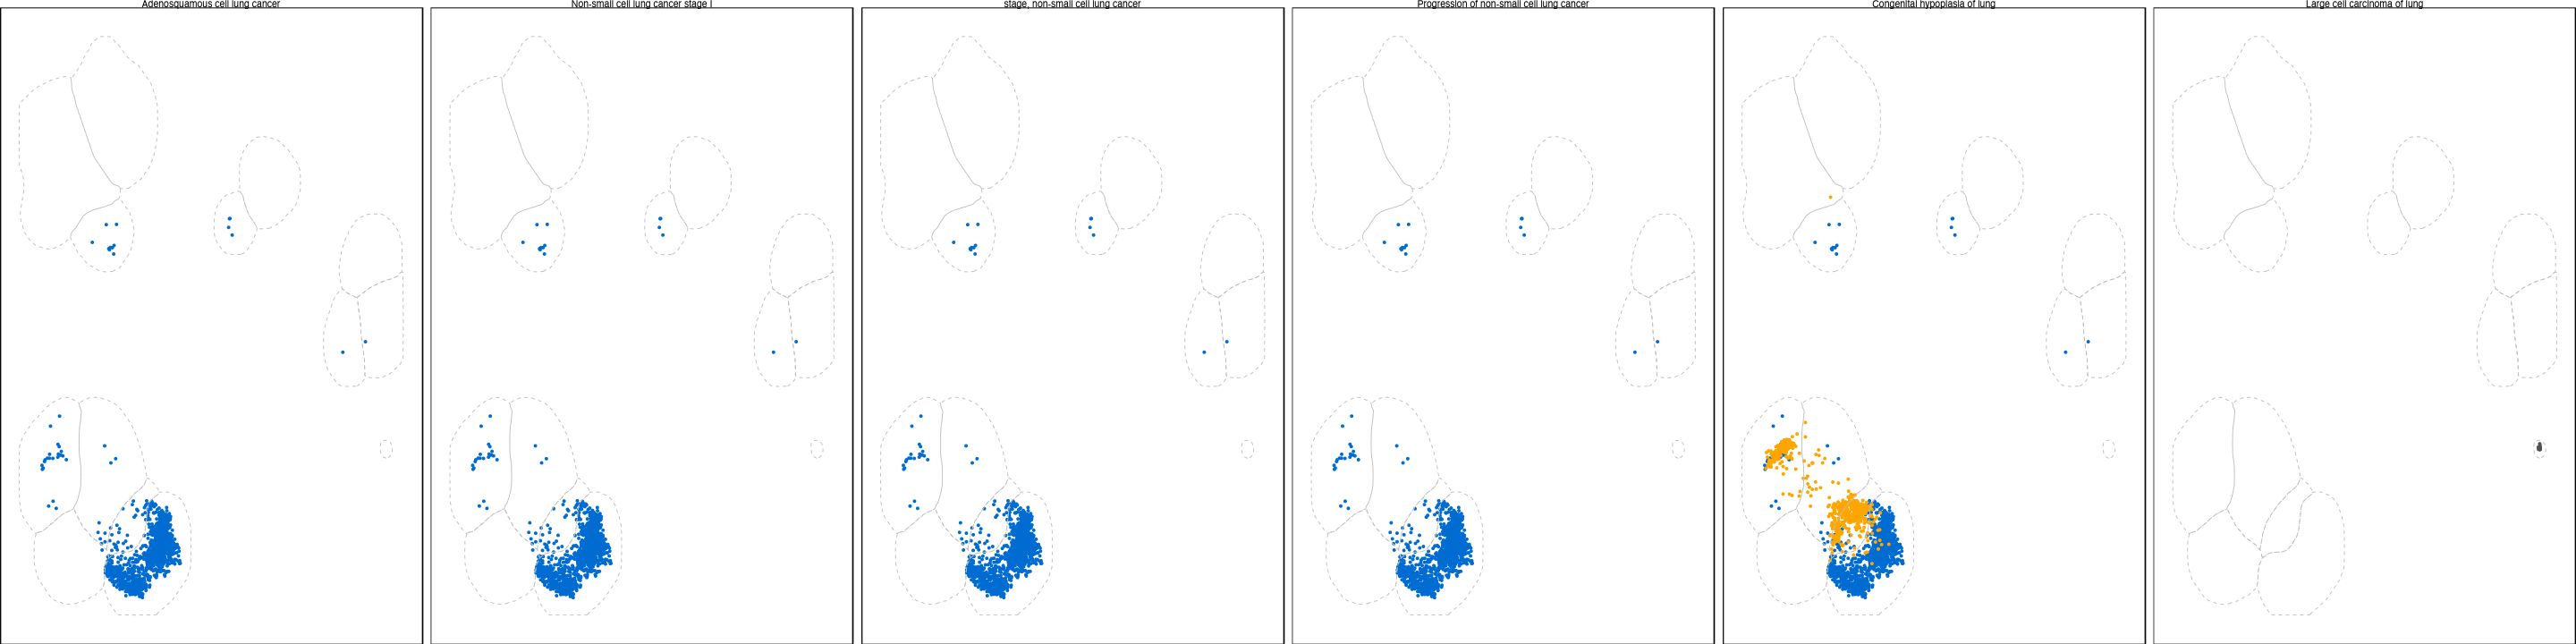

In [421]:


options(repr.plot.width=24, repr.plot.height=6)
a =melt(tmp_umap_df, id.vars = c('UMAP_1', 'UMAP_2', 'new_name'))  %>%
  filter(value>0) %>%
  # filter(new_name!='Airway_Spock3.4') %>%
  #filter(variable=='Adenosquamous cell lung cancer') %>%
  ggplot(aes(x = UMAP_1, y = UMAP_2)) + 
  #stat_density_2d(aes(fill = ..density..), geom = "raster",contour = F, adjust = 10) + 
  geom_point(aes(color=new_name),size = .5, shape=16) + 
  facet_wrap(~variable, nrow = 1) + 
  scale_color_manual(values = tmp_curr_celltype_color2) +
  geom_path(data=maskTable, aes(x=umap_1,y=umap_2,group=group),linewidth=0.2,linetype = 2, colour ="gray") +
  #scale_fill_viridis(option="magma") + 
  #galaxyTheme_black() + 
  #lims(x=xlim_manual, y=ylim_manual) +
  theme_void() +
  theme(strip.text = element_text(size=6),  # remove facet title
        legend.position = "none" ,
        panel.border = element_rect(fill=NA, color='black'))   # remove legend
a
ggsave(glue('{output_dir}/P0_nek10_density2.pdf'), a,
       width=210, height=40, units='mm', dpi=600, bg='transparent')

In [411]:
p0_srt_sub = subset(p0_srt, Time=='P7')
tmp_umap_df = p0_srt_sub@meta.data
tmp_umap_df = tmp_umap_df[, c('new_name'), drop=F]
tmp_umap_df[, c('UMAP_1', 'UMAP_2')] = p0_srt_sub@reductions$umap@cell.embeddings

In [413]:
tmp_lung_res0_P0 = tmp_lung_res0 %>% filter(Time=='P7')
for(i in unique(tmp_lung_res0_P0$Description)){
    tmp_genes = tmp_lung_res0_P0 %>% filter(Description==i) %>% pull(Celltype)
    #print(tmp_genes)
    if(tmp_genes[1]=='AT1_Spock2.116') {
        tmp_genes='AT1.116'
    }
    tmp_umap_df[, i] = 0
    tmp_umap_df[tmp_umap_df$new_name%in%tmp_genes, i] = 1
}

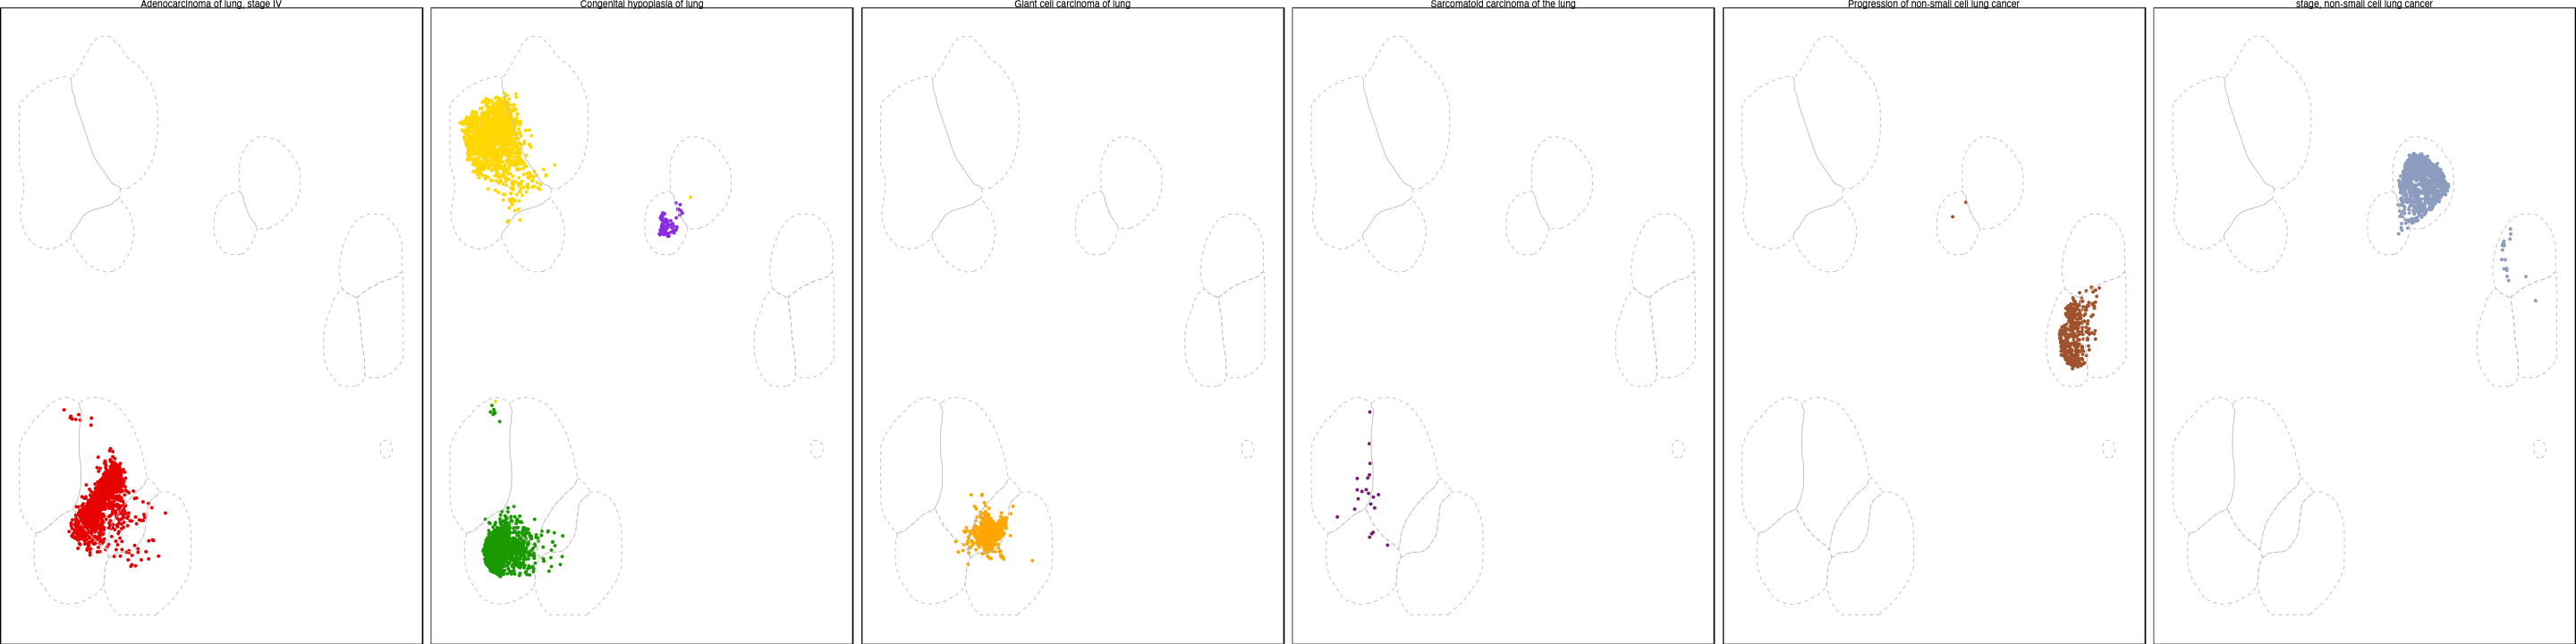

In [417]:


options(repr.plot.width=24, repr.plot.height=6)
a =melt(tmp_umap_df, id.vars = c('UMAP_1', 'UMAP_2', 'new_name'))  %>%
  filter(value>0) %>%
  # filter(new_name!='Airway_Spock3.4') %>%
  #filter(variable=='Adenosquamous cell lung cancer') %>%
  ggplot(aes(x = UMAP_1, y = UMAP_2)) + 
  #stat_density_2d(aes(fill = ..density..), geom = "raster",contour = F, adjust = 10) + 
  geom_point(aes(color=new_name),size = 0.5, shape=16) + 
  facet_wrap(~variable, nrow = 1) + 
  scale_color_manual(values = tmp_curr_celltype_color2) +
  geom_path(data=maskTable, aes(x=umap_1,y=umap_2,group=group),linewidth=0.2,linetype = 2, colour ="gray") +
  #scale_fill_viridis(option="magma") + 
  #galaxyTheme_black() + 
  #lims(x=xlim_manual, y=ylim_manual) +
  theme_void() +
  theme(strip.text = element_text(size=6),  # remove facet title
        legend.position = "none" ,
        panel.border = element_rect(fill=NA, color='black'))   # remove legend
a
ggsave(glue('{output_dir}/P7_density2.pdf'), a,
       width=210, height=40, units='mm', dpi=600, bg='transparent')

In [ ]:
mm10_hg38_homoGene = read.csv('./placeholder_project/genome_annotation_file/mm10_hg38_homoGene_ensembl.csv')
#background_gene = unique(na.omit(mm10_hg38_homoGene$Human.gene.name))
head(mm10_hg38_homoGene)

In [196]:
p0_srt_sub = subset(p0_srt, Time=='P0')

In [436]:
tmp_all_gene = unname(unlist(celltye_time_disease_genes_1[['AT1_Nek10.112:P0']]))
tmp_all_gene = sapply(tmp_all_gene, function(x){
    paste0(substr(x,1,1), tolower(substr(x,2,nchar(x))))
    }
)
tmp_all_gene = unname(tmp_all_gene)

In [437]:
gene_activity = GeneActivity(p0_srt,features = tmp_all_gene)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [439]:
p0_srt[['RNA']] = CreateAssayObject(counts=gene_activity)
DefaultAssay(p0_srt) = 'RNA'
p0_srt = NormalizeData(p0_srt, assay = 'RNA', normalization.method = 'LogNormalize',
                    scale.factor = median(p0_srt$nCount_RNA))

In [ ]:
umap = read.csv(glue('./placeholder_analysis/round_cluster02/round1/Endothelium//cell_meta_ann.csv'))
rownames(umap) = umap$X

same_bc = intersect(umap$X,colnames(p0_srt))

head(unlist(umap[same_bc, c('UMAP_1')]))
p0_srt@reductions$umap@cell.embeddings[same_bc, 1] = unlist(umap[same_bc, c('UMAP_1')])
p0_srt@reductions$umap@cell.embeddings[same_bc, 2] = unlist(umap[same_bc, c('UMAP_2')])

In [885]:
density_colormap1 =c(
  "#313695",  # blue
  "#74ADD1",  # light blue
  "#FDAE61",  # orange
  "#D73027",  # red
  "#A50026"   # deep red
)
density_colormap2 =c(
  "#440154",  # deep purple / low value
  "#3B528B",  # blue
  "#21908C",  # cyan
  "#5DC863",  # green
  "#FDE725"   # high value / yellow
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


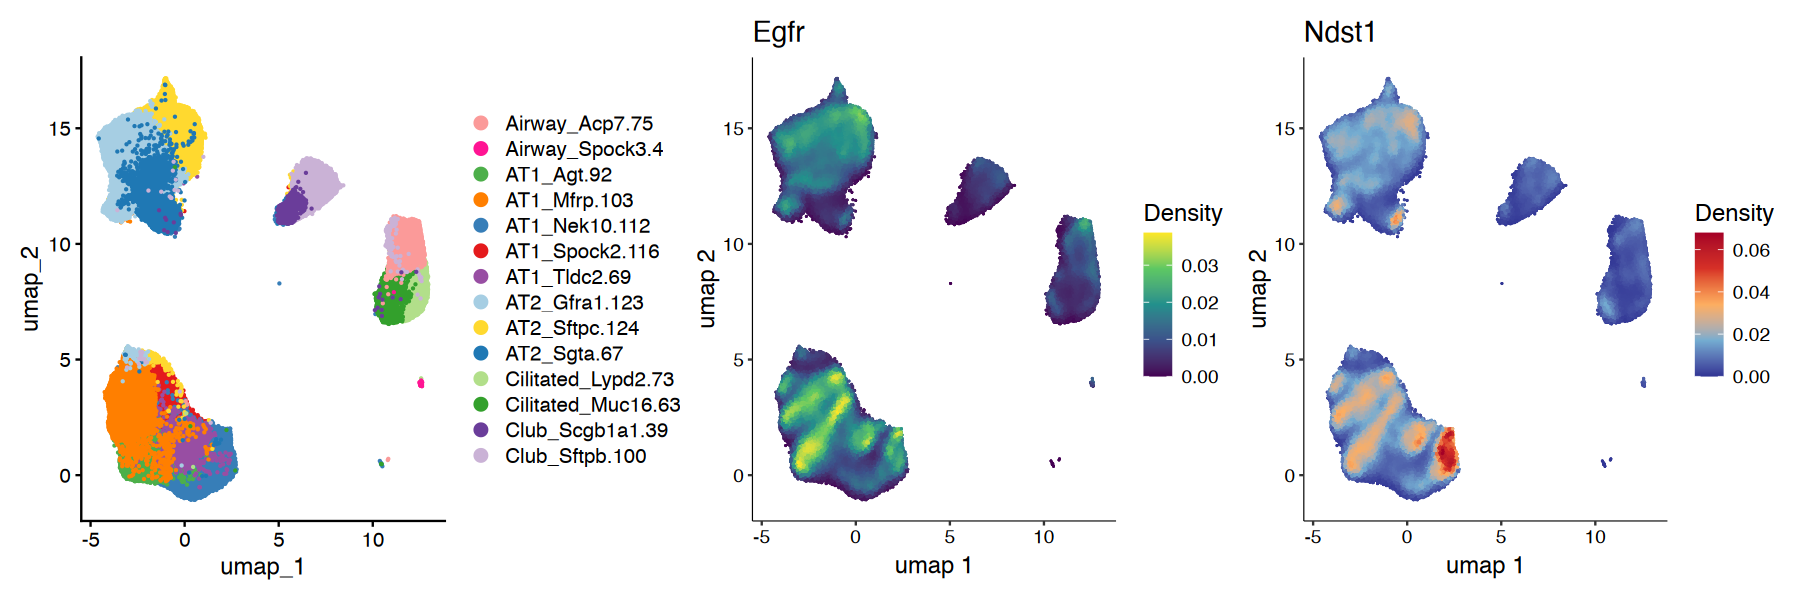

In [889]:
options(repr.plot.width=15, repr.plot.height=5)
p0_srt_sub = p0_srt#subset(p0_srt, Time=='P0')
a=DimPlot(p0_srt_sub, group.by = 'new_name', raster = F)+
    #theme(legend.position = 'none')+
    labs(title='')+
    scale_color_manual(values = tmp_curr_celltype_color2)
b=scCustomize::Plot_Density_Custom(seurat_object = p0_srt_sub, 
    features = c("Egfr"), viridis_palette= "viridis", pt.size=0.5)&scale_color_gradientn(colours = density_colormap2)
c=scCustomize::Plot_Density_Custom(seurat_object = p0_srt_sub, 
    features = c('Ndst1'), viridis_palette= "viridis", pt.size=0.5)&scale_color_gradientn(colours = density_colormap1)
#b=FeaturePlot(p0_srt, features = 'Egfr', cols = c('lightgray', 'red'))
a+b+c

In [890]:
ggsave(glue('{output_dir}/AT1_egfr_ndst_umap.pdf'), a+b+c,  
       width=320, height = 100, units='mm', dpi=600, bg='transparent')